Overall Project

1. Section 1: Imports and Data Extraction
2. Section 2: Data Cleaning and Exploratory Analysis
3. Section 3: Data Preprocessing
4. Section 4: Machine Learning Models
5. Section 5: Fine-tuning of Models
6. Section 6: Data insights on Revenue


## Section 1: Data Extraction (Imports)

Sample Reference : https://dev.to/m0nica/how-to-use-the-tmdb-api-to-find-films-with-the-highest-revenue-82p

In [1]:
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # to format currency on charts axis

In [2]:
# API Key - The Movie Database Talk
import config # to hide TMDB API keys with config.py and .gitignore not to show API key in github
api_key = config.tmdb_api_key

In [3]:
response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&primary_release_year=2017&sort_by=revenue.desc')

In [4]:
#type(response)

### Discover movie details with multiple pages in API request
Extraction of data:

NOTE:
1. Obtain only movie titles with budget > 0
2. Change empty "production_countries : name" to 'NaN'
3. If empty list for 'cast' in movie credits : "mostPopularActor" to 'NaN'
4. Adding a new column "Year" to dataframe from "Release_Date"

In [5]:
def getMostPopularActor(noOfActors):
    print("No. of actors :", noOfActors)

    highestPopularityIndex = 0
    mostPopularActor = ''
    highestPopularity = 0.0

    for actorIndex in range(0,noOfActors):

      actorName = movie_credits['cast'][actorIndex]['name']
      actorPopularity = movie_credits['cast'][actorIndex]['popularity']

      # print("No :", actorIndex)
      # print('Actor : {} and Popularity : {}'.format(actorName, actorPopularity))

      if actorPopularity > highestPopularity:
          highestPopularityIndex = actorIndex
          mostPopularActor = actorName
          highestPopularity = actorPopularity

    # print('Index : {} of Most Popular Actor : {} with highest popularity : {}'.format(highestPopularityIndex, mostPopularActor, highestPopularity))

    return highestPopularityIndex, mostPopularActor, highestPopularity

In [6]:
%%time

# Maximum movies download is only 20,000 movies (= 20 * 1000 pages)
pageRange = range(1,502)

#columns = ['Film', 'Revenue', 'Budget', 'Release Date', 'Vote Average', 'Vote Count']
columns = ['ID', 'Film', 'Movie_Popularity', 'Duration', 'Revenue', 'Budget', 'Production_Country',
           'Release_Date', 'Vote_Average', 'Vote_Count', 'Actor_Index', 'Most_Popular_Actor', 'Actor_Popularity']
highest_revenue_ever_df = pd.DataFrame(columns=columns)

filmCtr = 1

for pageCount in pageRange:
    print('Fetch page no :', pageCount)
    print('-' * 20)
    pageCountStr = '&page=' + str(pageCount)

    # Need to change the page string and cannot use '&page=pageCount'
    response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&sort_by=revenue.desc' + pageCountStr)

    highest_revenue_ever = response.json()

    # Only upto 500 pages
    if highest_revenue_ever.get('results') == None:
        print("\n**** No results from API ****")
        print("*" * 41)
        print()
        continue

    highest_revenue_films_ever = highest_revenue_ever['results']

    for film in highest_revenue_films_ever:
        # print(film['title'])

        # Get movie details : .../movie/{movie_id}...
        film_revenue = requests.get('https://api.themoviedb.org/3/movie/'+ str(film['id']) +'?api_key='+ api_key+'&language=en-US')
        film_revenue = film_revenue.json()
        #print(film_revenue)

        # print(locale.currency(film_revenue['revenue'], grouping=True ))

        # Need to check for error before finding budget
        if film_revenue.get('budget') == None:
            print("\n**** KeyError for budget ****")
            print('Error Status Code : {}, Message : {}'.format(film_revenue.get('status_code'), film_revenue.get('status_message')))
            print("*" * 82)
            print()
        elif film_revenue['budget'] > 0:
            print('No. : {}, Title : {}, Budget : ${:,.2f}M'.format(filmCtr, film_revenue['title'], film_revenue['budget']/1000000))
            print('-'* 60)

            # Example : 'production_countries': [{'iso_3166_1': 'US', 'name': 'United States of America'}]
            # Preprocessing : If empty list, set to default, unknown_production_country
            if not film_revenue['production_countries']:
                unknown_production_country = {'iso_3166_1': 'US','name' : np.nan}
                film_revenue['production_countries'].append(unknown_production_country)
                print("\n**** No production country!!! ****")
                print("Preprocessed production_countries :\n", film_revenue['production_countries'])
                print("*" * 82)

            # Get movie credits : .../movie/{movie_id}/credits...
            movie_credits = requests.get('https://api.themoviedb.org/3/movie/'+ str(film['id']) +'/credits?api_key='+ api_key +'&language=en-US')
            movie_credits = movie_credits.json()

            # Title : Alex undskylder dick pics, No. of actors : 0 in empty ['cast']
            if len(movie_credits['cast']) > 0:
                # print('ID : {}, Cast : {}'.format(movie_credits['id'], movie_credits['cast']))
                highestPopularityIndex, mostPopularActor, highestPopularity = getMostPopularActor(len(movie_credits['cast']))
                print('Index : {} of Most Popular Actor : {} with highest popularity : {}'.format(highestPopularityIndex,
                                                                                                  mostPopularActor, highestPopularity))
                print('')
            else:
                # Preprocessing : If empty list, set to default, mostPopularActor as NaN
                highestPopularityIndex, mostPopularActor, highestPopularity = 0, np.nan, 0.0
                print("**** Empty cast and NO actor recorded for this movie title! ****")
                print('**** Replaced with highestPopularityIndex : {}, mostPopularActor : {}, highestPopularity : {} ****'\
                      .format(highestPopularityIndex, mostPopularActor, highestPopularity))
                print("*" * 82)
                print('')
                ##

            # add film title, revenue, budget, release date and other required information to the dataframe
            # also add highestPopularityIndex, mostPopularActor and highestPopularity to the dataframe
            highest_revenue_ever_df.loc[len(highest_revenue_ever_df)]=[film_revenue['id'], film_revenue['title'], film_revenue['popularity'],
                                                                       film_revenue['runtime'], (film_revenue['revenue']/1000000),
                                                                       (film_revenue['budget']/1000000),
                                                                       film_revenue['production_countries'][0]['name'], film_revenue['release_date'],
                                                                       film_revenue['vote_average'], film_revenue['vote_count'],
                                                                       highestPopularityIndex, mostPopularActor, highestPopularity]
        else:
            print("\n**** Budget is smaller or equal to 0 ****")
            print('No. : {}, Title : {}, Budget : {}'.format(filmCtr, film_revenue['title'], locale.currency(film_revenue['budget'])))
            print("*" * 41)
            print()

        filmCtr += 1

    print()

highest_revenue_ever_df.head()

Streaming output truncated to the last 5000 lines.
No. of actors : 4
Index : 0 of Most Popular Actor : Alfred Molina with highest popularity : 7.126


**** Budget is smaller or equal to 0 ****
No. : 9060, Title : Reklam, Budget : $0.00
*****************************************


Fetch page no : 454
--------------------

**** Budget is smaller or equal to 0 ****
No. : 9061, Title : The Trip, Budget : $0.00
*****************************************

No. : 9062, Title : Zindagi Kitni Haseen Hay, Budget : $0.28M
------------------------------------------------------------
No. of actors : 11
Index : 1 of Most Popular Actor : Sajal Ali with highest popularity : 1.4

No. : 9063, Title : The Informer, Budget : $0.24M
------------------------------------------------------------
No. of actors : 35
Index : 7 of Most Popular Actor : Joe Sawyer with highest popularity : 2.588


**** Budget is smaller or equal to 0 ****
No. : 9064, Title : Fanboys, Budget : $0.00
************************************

### Check on details

In [9]:
film_revenue

{'adult': False,
 'backdrop_path': '/zIEw1vx6vouTSrMNmskPOh5Imvc.jpg',
 'belongs_to_collection': None,
 'budget': 100000,
 'genres': [{'id': 35, 'name': 'Comedy'}],
 'homepage': '',
 'id': 672815,
 'imdb_id': None,
 'original_language': 'en',
 'original_title': "ALL COPS AIN'T BAD",
 'overview': '\xa0Everyone\'s heard the story from comedians about the convict or arrestee, NEVER have you heard the story from the actual Cop.\xa0 You heard right! How about hearing these gut busting stories from a real "OFFICER". Watch Comedian Daryll Triplett aka Officer Keep It Real as he does nothing, but Keep It Real....',
 'popularity': 1.293,
 'poster_path': '/5WTFnZuu6uOjD6R8Lh7yDLEJFMU.jpg',
 'production_companies': [{'id': 129132,
   'logo_path': None,
   'name': 'VH2 Networks',
   'origin_country': ''}],
 'production_countries': [{'iso_3166_1': 'US',
   'name': 'United States of America'}],
 'release_date': '2020-01-01',
 'revenue': 350000,
 'runtime': 0,
 'spoken_languages': [],
 'status': 'Rel

In [10]:
film_revenue['production_countries'][0]['name']

'United States of America'

In [11]:
# Adding release year to dataframe

highest_revenue_ever_df['Year'] = pd.DatetimeIndex(highest_revenue_ever_df['Release_Date']).year.fillna(0).astype(int)
print(highest_revenue_ever_df)

          ID                          Film  ...  Actor_Popularity  Year
0     299534             Avengers: Endgame  ...            34.160  2019
1      19995                        Avatar  ...            13.223  2009
2        597                       Titanic  ...            18.830  1997
3     140607  Star Wars: The Force Awakens  ...            15.398  2015
4     299536        Avengers: Infinity War  ...            34.160  2018
...      ...                           ...  ...               ...   ...
7134   43937           Like Dandelion Dust  ...             5.114  2009
7135  609031        My Thoughts Are Silent  ...             1.400  2020
7136  214086              The Face of Love  ...            12.792  2013
7137  750182                 Short Circuit  ...             0.600  2019
7138  672815            ALL COPS AIN'T BAD  ...             0.600  2020

[7139 rows x 14 columns]


In [12]:
print("Data frame keys :", highest_revenue_ever_df.keys())

Data frame keys : Index(['ID', 'Film', 'Movie_Popularity', 'Duration', 'Revenue', 'Budget',
       'Production_Country', 'Release_Date', 'Vote_Average', 'Vote_Count',
       'Actor_Index', 'Most_Popular_Actor', 'Actor_Popularity', 'Year'],
      dtype='object')


In [13]:
highest_revenue_ever_df.shape

(7139, 14)

In [14]:
# Save dataframe to CSV file for data analytics
highest_revenue_ever_df.to_csv('TMDB_Movies.csv', index=False)

## Section 2a: Cleaning of data (Start running from here with excel file)
1. Load CSV files
2. Find out missing values
3. Picking your predictors/features and response variable (To clean) 

Reference : https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

### Imports for DataAnalysis

In [15]:
import sklearn
import os
import pandas as pd
import numpy as np
import csv

#Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

#Saving of figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "TMDB"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def load_data(filename):
    return pd.read_csv(filename)

In [16]:
#Loading Dataset

complete_data = load_data("TMDB_Movies.csv")
len(complete_data)

7139

### Observations on DataSet 

Finding out which variables have missing values

In [17]:
complete_data.head()

,ID,Film,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Release_Date,Vote_Average,Vote_Count,Actor_Index,Most_Popular_Actor,Actor_Popularity,Year
0,299534,Avengers: Endgame,252.917,181.0,2797.800564,356.0,United States of America,2019-04-24,8.3,18049,4,Scarlett Johansson,34.160,2019
1,19995,Avatar,91.015,162.0,2787.965087,237.0,United States of America,2009-12-10,7.5,23336,4,Michelle Rodriguez,13.223,2009
2,597,Titanic,71.200,194.0,2187.463944,200.0,United States of America,1997-11-18,7.9,19132,0,Leonardo DiCaprio,18.830,1997
3,140607,Star Wars: The Force Awakens,66.810,136.0,2068.223624,245.0,United States of America,2015-12-15,7.4,15758,67,Ewan McGregor,15.398,2015
4,299536,Avengers: Infinity War,307.301,149.0,2046.239637,300.0,United States of America,2018-04-25,8.3,21715,3,Scarlett Johansson,34.160,2018


In [18]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7139 non-null   int64  
 1   Film                7139 non-null   object 
 2   Movie_Popularity    7139 non-null   float64
 3   Duration            7136 non-null   float64
 4   Revenue             7139 non-null   float64
 5   Budget              7139 non-null   float64
 6   Production_Country  7006 non-null   object 
 7   Release_Date        7104 non-null   object 
 8   Vote_Average        7139 non-null   float64
 9   Vote_Count          7139 non-null   int64  
 10  Actor_Index         7139 non-null   int64  
 11  Most_Popular_Actor  7104 non-null   object 
 12  Actor_Popularity    7139 non-null   float64
 13  Year                7139 non-null   int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 781.0+ KB


In [19]:
complete_data.shape

(7139, 14)

Observations:

Missing value columns: Duration, Production_Country, Release_Date, Most_Popular Actor

In [20]:
# Store indexes to incomplete rows in loaded dataset
sample_incomplete_rows = complete_data[complete_data.isnull().any(axis=1)] # add .head() is just want to have the top 5
sample_incomplete_rows

,ID,Film,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Release_Date,Vote_Average,Vote_Count,Actor_Index,Most_Popular_Actor,Actor_Popularity,Year
43,811017,Alex undskylder dick pics,0.600,0.0,1000.000000,10.000000,NaN,NaN,0.0,0,0,NaN,0.000,0
44,766406,15 Killings,2.792,97.0,1000.000000,10.000000,NaN,2020-12-04,5.9,4,4,Maria Olsen,0.608,2020
45,761478,The One You Feed,3.177,86.0,1000.000000,10.000000,NaN,2021-04-25,0.0,0,0,Rebecca Fraiser,0.600,2021
49,792149,Dead Again,2.005,75.0,999.999999,999.999999,NaN,2021-01-04,6.3,3,0,NaN,0.000,2021
75,782042,Властелин Колец - Братва и Кольцо,0.600,0.0,871.530324,93.000000,NaN,2001-01-01,0.0,0,0,NaN,0.000,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,207490,Luminarias,0.600,100.0,0.428535,1.000000,NaN,2000-05-05,0.0,0,0,NaN,0.000,2000
7079,681698,MagicalDemons,0.600,90.0,0.420000,0.090000,NaN,NaN,0.0,0,0,NaN,0.000,0
7090,539411,Khandan,0.600,158.0,0.408198,0.204099,NaN,1965-09-23,0.0,0,1,Lalita Pawar,1.400,1965
7097,547630,Restricted Area: Baron Palace,0.600,85.0,0.400000,0.250000,NaN,2016-11-16,0.0,0,0,yasmine omar,0.600,2016


In [21]:
numeric_feature_count = 0
non_numeric_feature_count = 0

for col in complete_data.columns:
  if (complete_data[col].dtypes == 'int64') or (complete_data[col].dtypes == 'float64'):
    numeric_feature_count += 1
    print("Numeric feature No. {} and name : {}".format(numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}, Median values : {}".\
      format(complete_data[col].isnull().sum(), (complete_data[col] == 0).sum(),
             (complete_data[col] == complete_data[col].median()).sum()))
    print("-" * 70)
    print()
  else:
    non_numeric_feature_count += 1
    print("Non-numeric feature No. {} and name : {}".format(non_numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}".\
      format(complete_data[col].isnull().sum(), (complete_data[col] == 0).sum()))
    print("-" * 50)
    print()

print("Total No. of Numeric features {} and Non-numeric features : {}".format(numeric_feature_count, non_numeric_feature_count))

Numeric feature No. 1 and name : ID
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Non-numeric feature No. 1 and name : Film
No. of Missing values : 0, Zero values : 0
--------------------------------------------------

Numeric feature No. 2 and name : Movie_Popularity
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 3 and name : Duration
No. of Missing values : 3, Zero values : 46, Median values : 142
----------------------------------------------------------------------

Numeric feature No. 4 and name : Revenue
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 5 and name : Budget
No. of Missing values : 0, Zero values : 0, Median values : 73
----------------------------------------------------

**Observations**

Features with missing values
1. Duration(3)
2. Production country(135)
3. Release Date(33)
4. Most Popular Actor (34)

Features with values of 0
1. Duration(43)
2. Movie Popularity(1)
2. Vote Average(92)
4. Vote Count(92)
5. Actor_index(2256)
6. Actor popularity(34)
7. Year(33)



In [22]:
complete_data.dtypes

ID                      int64
Film                   object
Movie_Popularity      float64
Duration              float64
Revenue               float64
Budget                float64
Production_Country     object
Release_Date           object
Vote_Average          float64
Vote_Count              int64
Actor_Index             int64
Most_Popular_Actor     object
Actor_Popularity      float64
Year                    int64
dtype: object

## Section 2b: Exploratory Data Analysis (Assist Cleaning Process)
Using exploratory analysis to decide predictors and response variables to be used

1. Pick features to use for training and response variable
2. Fill up missing values (Use of imputer except for **Production_Country**)
3. Transform production country to regions
4. Transforming zero and missing values to medians

Use of imputer avoid the deletion of the 2% missing and incomplete data. (In pipeline later)

*  float64 : ['ID', 'Movie_Popularity', 'Duration', 'Revenue', 'Budget', 'Vote_Average', 'Actor_Popularity'] 
*   object : ['Film', 'Production_Country', 'Release_Date', 'Most_Popular_Actor']
*   int64 : ['Vote_Count', 'Actor_Index', 'Year']
*   Explore : ['Vote_Count', 'Most_Popular_Actor', 'Actor_Popularity']

### Analysis to pick features

Use of correlation to take a look at features correlation to revenue

In [23]:
budget = pd.DataFrame(complete_data["Budget"])
budget.head()
revenue = pd.DataFrame(complete_data["Revenue"])
revenue.head()
numeric_rows = complete_data.drop(columns = ['ID', 'Film', 'Release_Date', 'Actor_Index', 'Most_Popular_Actor', 'Year','Production_Country'])
numeric_rows.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,252.917,181.0,2797.800564,356.0,8.3,18049,34.160
1,91.015,162.0,2787.965087,237.0,7.5,23336,13.223
2,71.200,194.0,2187.463944,200.0,7.9,19132,18.830
3,66.810,136.0,2068.223624,245.0,7.4,15758,15.398
4,307.301,149.0,2046.239637,300.0,8.3,21715,34.160


In [24]:
for var in numeric_rows.columns:
    col_data = pd.DataFrame(numeric_rows[var])
    print(col_data.describe())

       Movie_Popularity
count       7139.000000
mean          20.102347
std           83.970793
min            0.600000
25%            8.167500
50%           12.349000
75%           19.277000
max         5441.414000
          Duration
count  7136.000000
mean    110.683296
std      24.795783
min       0.000000
25%      95.000000
50%     107.000000
75%     122.250000
max     420.000000
           Revenue
count  7139.000000
mean     84.199345
std     170.523646
min       0.350000
25%       5.591677
50%      23.355100
75%      85.290125
max    2797.800564
            Budget
count  7139.000000
mean     28.495086
std      42.543838
min       0.000001
25%       4.000000
50%      14.000000
75%      35.000000
max     999.999999
       Vote_Average
count   7139.000000
mean       6.345567
std        1.175854
min        0.000000
25%        5.900000
50%        6.500000
75%        7.000000
max       10.000000
         Vote_Count
count   7139.000000
mean    1561.997198
std     2735.112341
min        

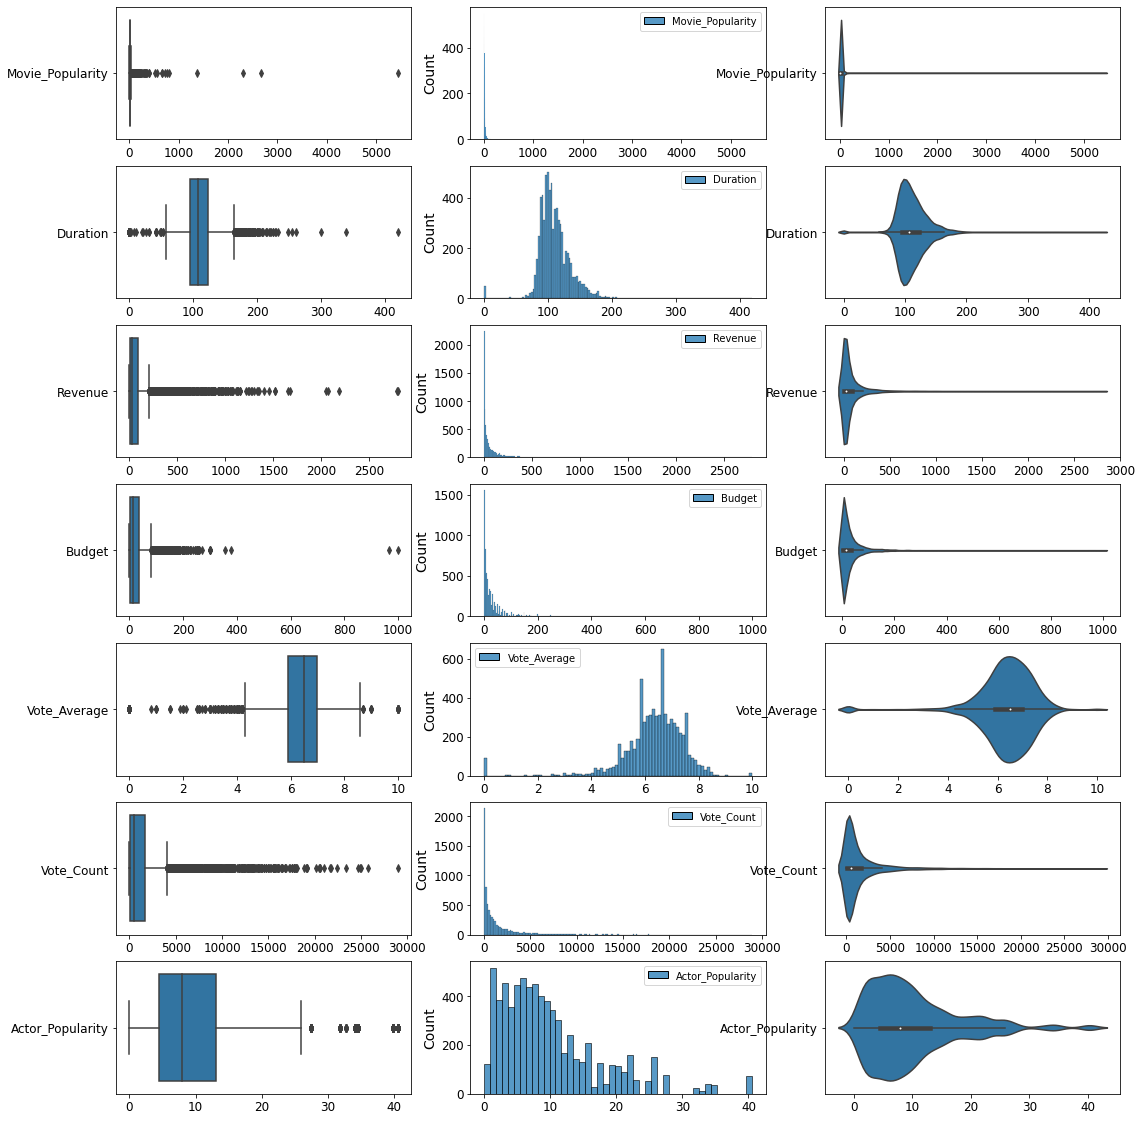

In [25]:
# Draw the distributions of all variables
f, axes = plt.subplots(7, 3, figsize=(18, 20))
count = 0
for var in numeric_rows.columns:
    col_data = pd.DataFrame(numeric_rows[var])
    sns.boxplot(data = col_data, orient = "h", ax = axes[count,0])
    sns.histplot(data = col_data, ax = axes[count,1])
    sns.violinplot(data = col_data, orient = "h", ax = axes[count,2])
    count += 1
    

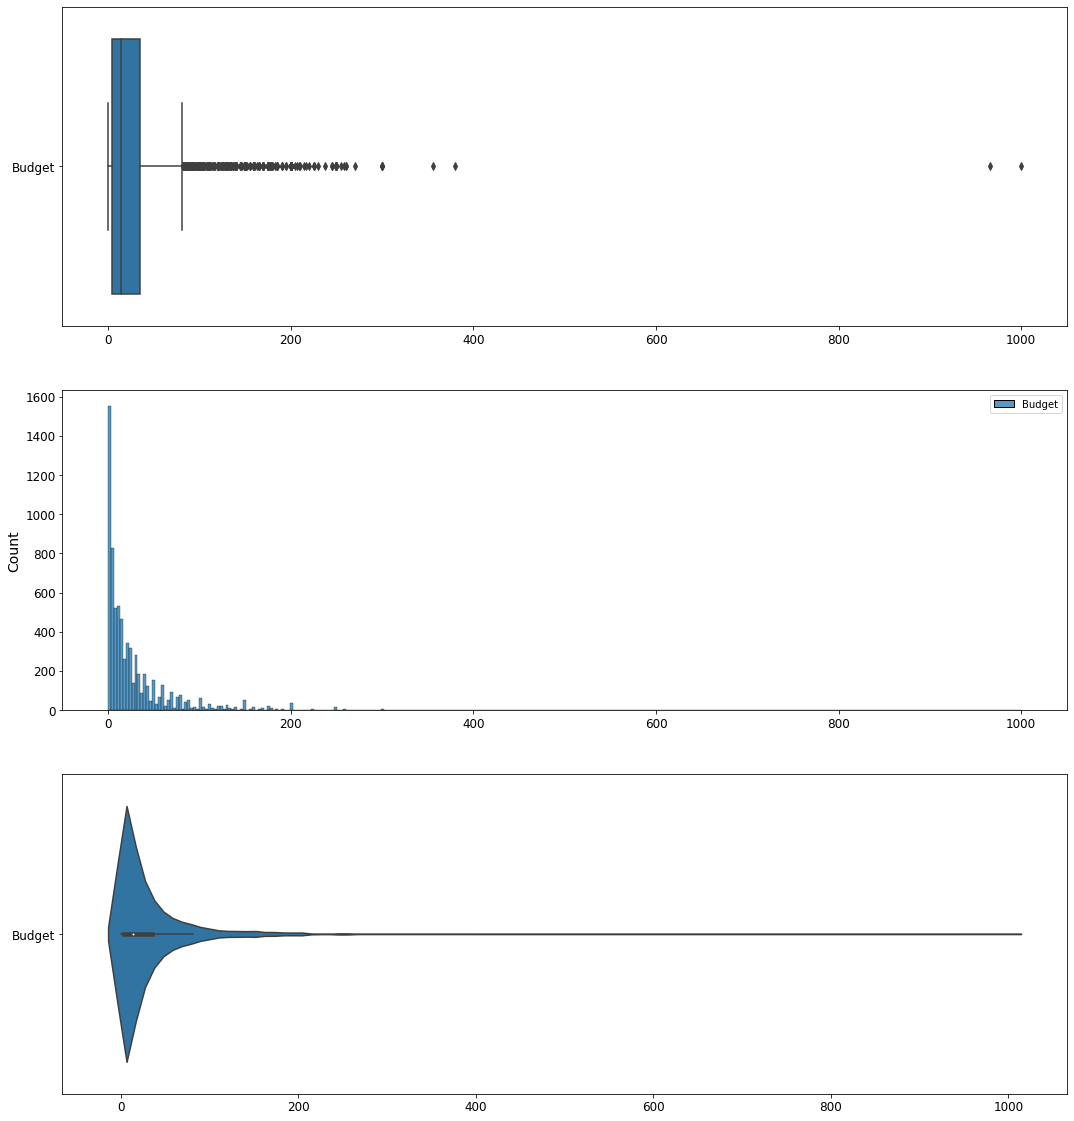

In [26]:
# Close up distribution of budget
f, axes = plt.subplots(3, 1, figsize=(18, 20))
sns.boxplot(data = budget, orient = "h", ax = axes[0])
sns.histplot(data = budget, ax = axes[1])
sns.violinplot(data = budget, orient = "h", ax = axes[2])


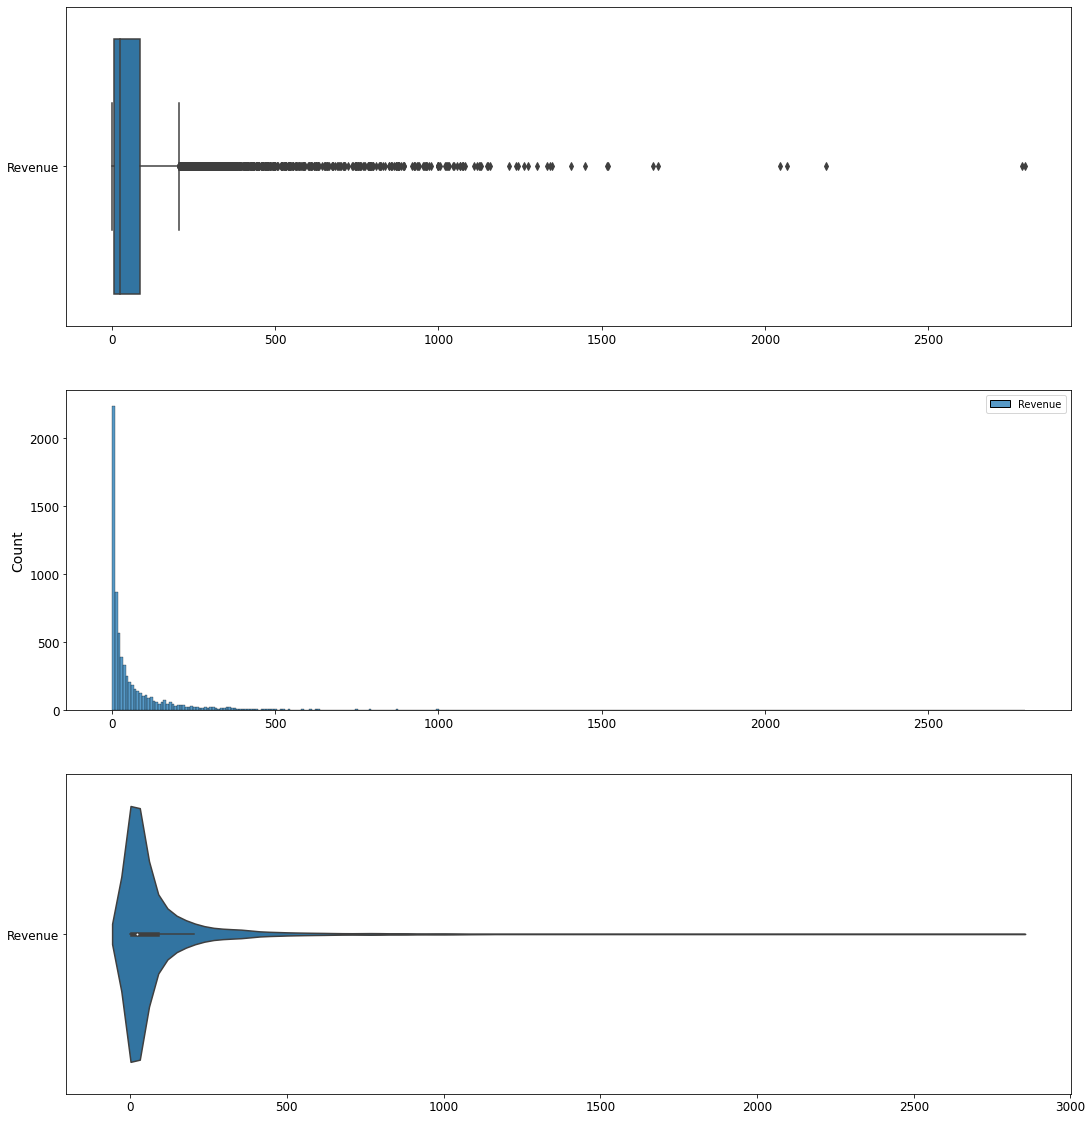

In [27]:
# CLose up distribution of Revenue
f, axes = plt.subplots(3, 1, figsize=(18, 20))
sns.boxplot(data = revenue, orient = "h", ax = axes[0])
sns.histplot(data = revenue, ax = axes[1])
sns.violinplot(data = revenue, orient = "h", ax = axes[2])


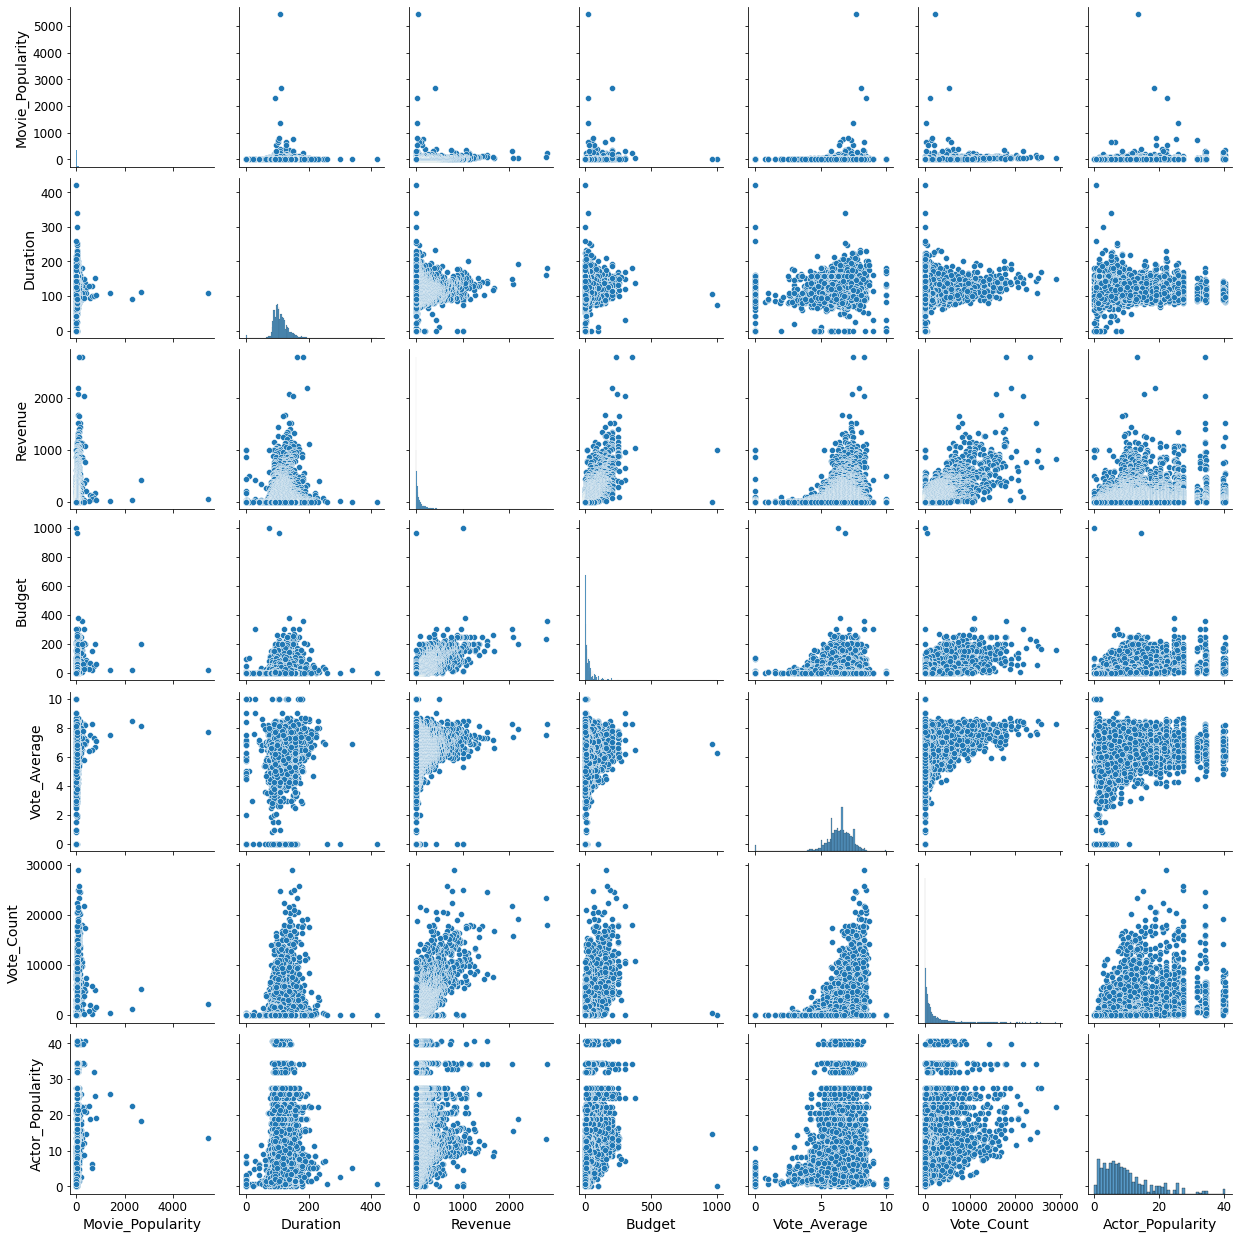

In [28]:
# Draw pairs of variables against one another
sns.pairplot(data = numeric_rows)

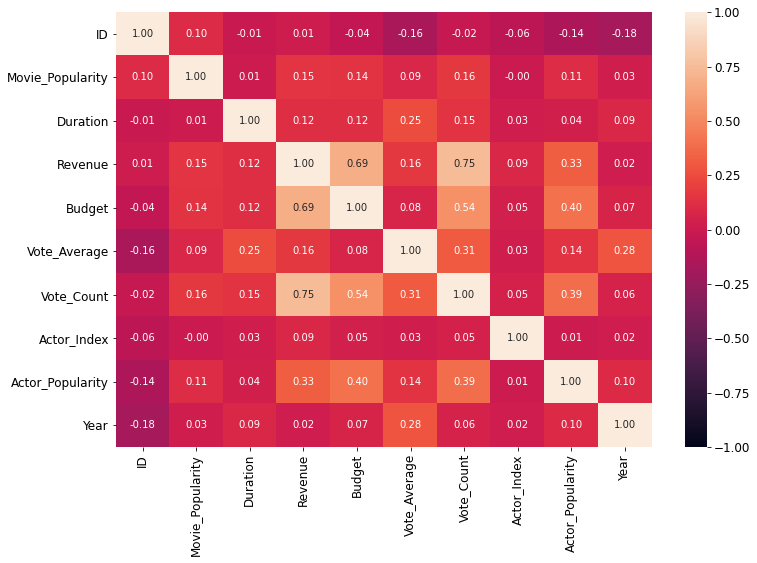

In [29]:
f = plt.figure(figsize=(12, 8))
sns.heatmap(complete_data.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [30]:
#Correlation of all variables with Revenue alone

corr_matrix = complete_data.corr()
corr_matrix["Revenue"].sort_values(ascending=False)

# 'Vote_Count', 'Budget' and 'Actor_Popularity' are the topmost correlated attributes with the target, 'Revenue'

Revenue             1.000000
Vote_Count          0.748301
Budget              0.686622
Actor_Popularity    0.325173
Vote_Average        0.164675
Movie_Popularity    0.151456
Duration            0.123479
Actor_Index         0.093147
Year                0.022873
ID                  0.010265
Name: Revenue, dtype: float64

**It is also useful to observe correlations with the highest correlated variable**

Variables that are very high correlated to the highest correlated variable may not be useful as very little independence. Does not give much information since both variables will give same direction to Revenue. (Especially in decision trees and Random Forest)

In [31]:
# Getting the standard correlation coefficient (Pearson Correlation) between every attributes with attribute
corr_matrix["Vote_Count"].sort_values(ascending=False)

# 'Revenue', 'Budget', 'Actor_Popularity' and 'Vote_Average' are the topmost correlated attributes with the attribute, 'Vote_Count'

Vote_Count          1.000000
Revenue             0.748301
Budget              0.544414
Actor_Popularity    0.387376
Vote_Average        0.308835
Movie_Popularity    0.164941
Duration            0.147141
Year                0.057505
Actor_Index         0.048405
ID                 -0.019925
Name: Vote_Count, dtype: float64

**Observations**

Based on correlation **Vote_Count, Budget and Actor Popularity** have pretty good correlation with **Revenue**

We exclude values with correlation of below 0.10 and below as too low to have any significant impact.

However, low correlations that are above 0.10 are still included such as **Movie_Popularity, Duration, Vote_Average** as they might still have an impact on revenue. Hence we included them as predictors/features.

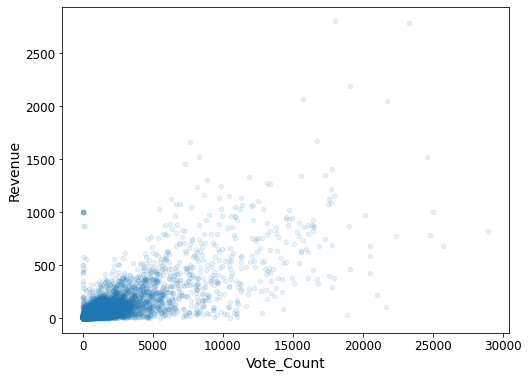

In [32]:
complete_data.plot(kind="scatter", x="Vote_Count", y="Revenue", figsize=(8, 6), alpha=0.1)

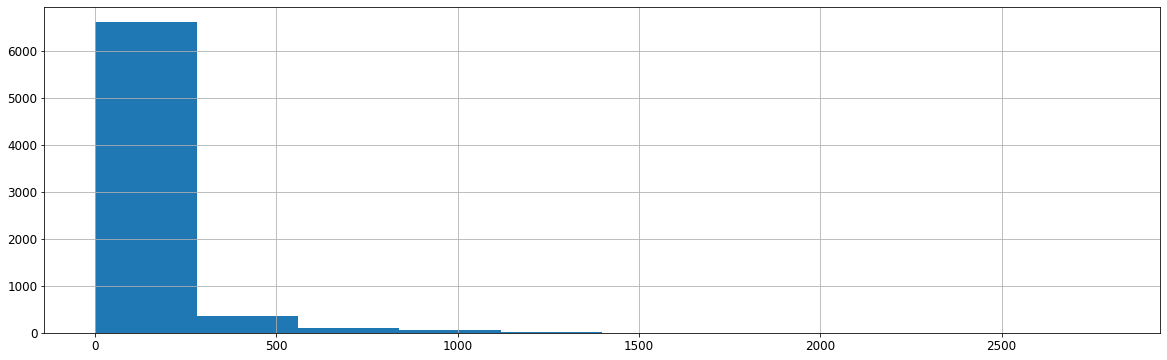

In [33]:
complete_data['Revenue'].hist(figsize=(20,6))

[Text(0, 0.5, 'Revenue (millions)'),
 Text(0.5, 0, 'Budget (millions)'),
 Text(0.5, 1.0, 'American Films with Highest Revenue')]

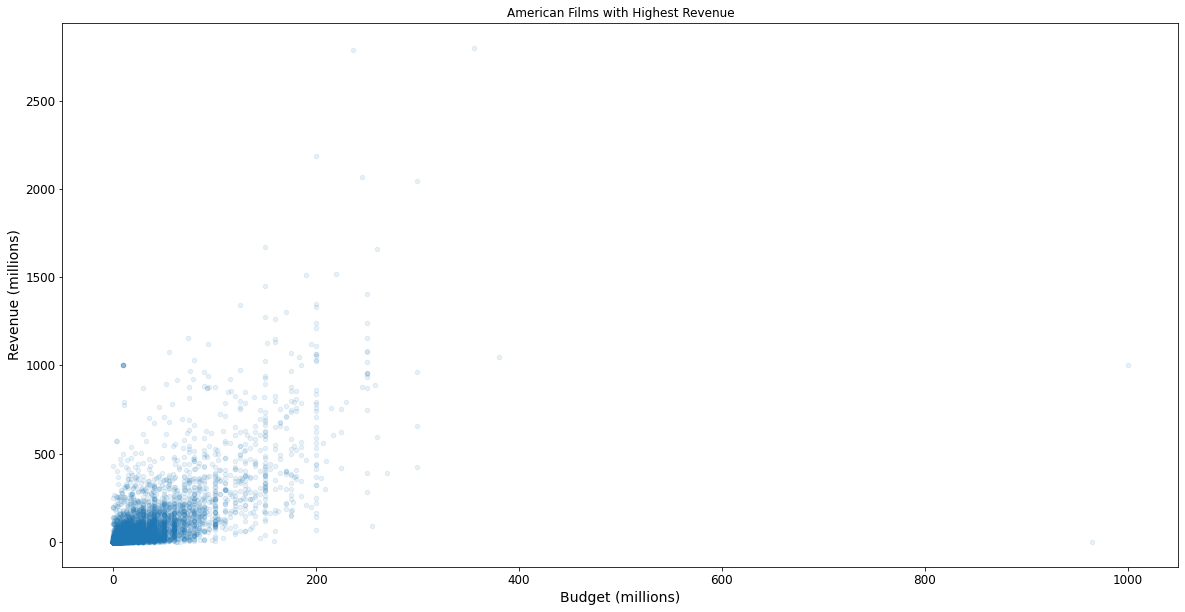

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))

complete_data.plot(kind="scatter", x="Budget", y="Revenue", alpha=0.1, ax=ax)
ax.set(title='American Films with Highest Revenue', xlabel='Budget (millions)', ylabel='Revenue (millions)')

[Text(0, 0.5, 'Revenue (millions)'),
 Text(0.5, 0, 'Duration (mins)'),
 Text(0.5, 1.0, 'American Films with Highest Revenue')]

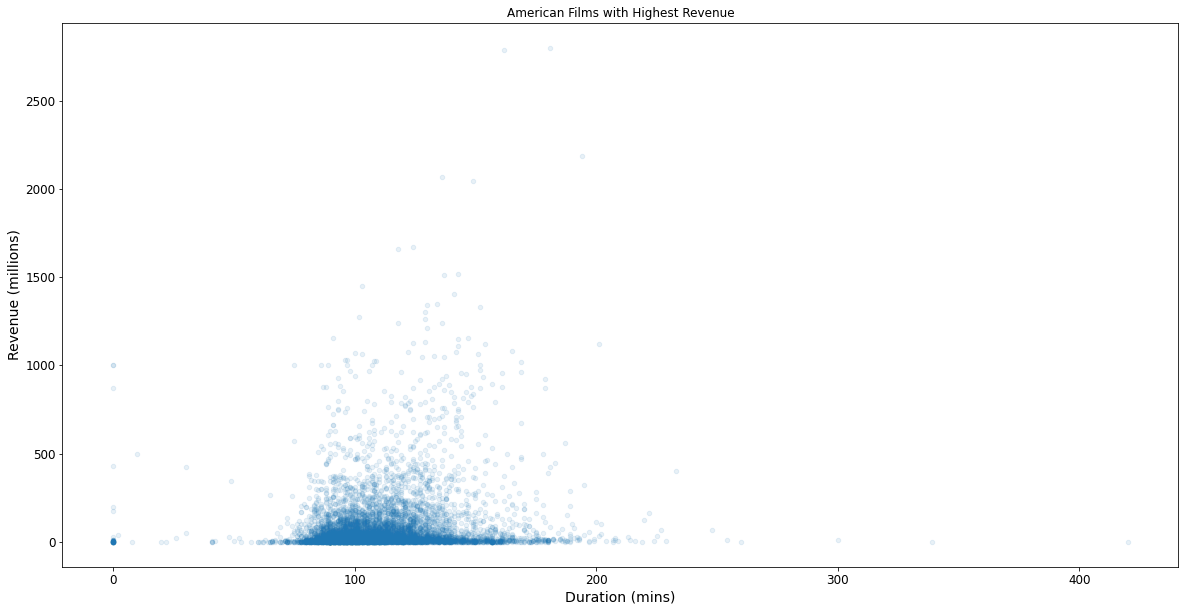

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))

complete_data.plot(kind="scatter", x="Duration", y="Revenue", alpha=0.1, ax=ax)
ax.set(title='American Films with Highest Revenue', xlabel='Duration (mins)', ylabel='Revenue (millions)')

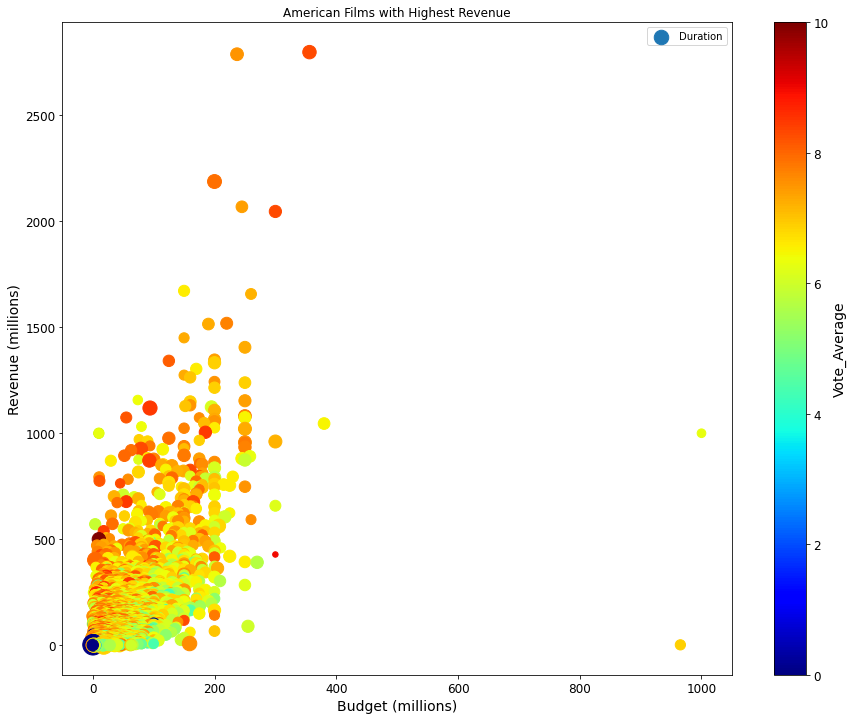

In [36]:
fig, ax = plt.subplots(figsize=(15,12))

# s (size) represents the 'Duration and  c (color) represents the 'Vote Average'
complete_data.plot(kind="scatter", x="Budget", y="Revenue", alpha=1.0,
                              s= "Duration", label="Duration", ax=ax,
                              c= "Vote_Average", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

ax.set(title='American Films with Highest Revenue', xlabel='Budget (millions)', ylabel='Revenue (millions)')
plt.legend()

**Observations**

**Color** represents Vote_Average
**Size** represents Duration

Generally Budget has a positive correlation relationship with Revenue, moreover the duration and vote average also seems to be higher. The colors are darker and bubble size is larger.

Even though correlation of Vote_Average with Revenue is only **0.3**, it generally becomes a darker color (Higher) as Revenue and Budget increases

### Filling up of missing values

We will remove columns: **'ID', 'Film', 'Release Date', 'Actor_Index', 'Most_Popular_Actor', 'Year'**

Hence:

Predictors/ Features: **Movie_Popularity, Duration, Budget(Millions), Production_Country, Vote_Average, Vote_Count, Actor_Popularity**

**Note** Production_Country is later replaced by Production_Country_Cat which is regions

Response variable: **Revenue(Millions)**


In [37]:
partial_dataset = complete_data.drop(columns = ['ID', 'Film', 'Release_Date', 'Actor_Index', 'Most_Popular_Actor', 'Year'])
partial_dataset.head()

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity
0,252.917,181.0,2797.800564,356.0,United States of America,8.3,18049,34.160
1,91.015,162.0,2787.965087,237.0,United States of America,7.5,23336,13.223
2,71.200,194.0,2187.463944,200.0,United States of America,7.9,19132,18.830
3,66.810,136.0,2068.223624,245.0,United States of America,7.4,15758,15.398
4,307.301,149.0,2046.239637,300.0,United States of America,8.3,21715,34.160


In [38]:
partial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie_Popularity    7139 non-null   float64
 1   Duration            7136 non-null   float64
 2   Revenue             7139 non-null   float64
 3   Budget              7139 non-null   float64
 4   Production_Country  7006 non-null   object 
 5   Vote_Average        7139 non-null   float64
 6   Vote_Count          7139 non-null   int64  
 7   Actor_Popularity    7139 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 446.3+ KB


Fill up missing values for **Production_Country**

In [39]:
# Check for missing values in Production Country
partial_dataset['Production_Country'].isnull().sum()

133

In [40]:
# Replace missing value, NaN, with default value 'Others'
partial_dataset['Production_Country'] = partial_dataset['Production_Country'].replace(np.nan, 'Others')
partial_dataset['Production_Country'].isnull().sum()

0

In [41]:
#Checking for countries with others
partial_dataset.loc[partial_dataset['Production_Country'] == 'Others']

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity
43,0.600,0.0,1000.000000,10.000000,Others,0.0,0,0.000
44,2.792,97.0,1000.000000,10.000000,Others,5.9,4,0.608
45,3.177,86.0,1000.000000,10.000000,Others,0.0,0,0.600
49,2.005,75.0,999.999999,999.999999,Others,6.3,3,0.000
75,0.600,0.0,871.530324,93.000000,Others,0.0,0,0.000
...,...,...,...,...,...,...,...,...
7074,0.600,100.0,0.428535,1.000000,Others,0.0,0,0.000
7079,0.600,90.0,0.420000,0.090000,Others,0.0,0,0.000
7090,0.600,158.0,0.408198,0.204099,Others,0.0,0,1.400
7097,0.600,85.0,0.400000,0.250000,Others,0.0,0,0.600


### Transforming of production countries to regions

In [42]:
# List unique values
print("No. of unique production countries :", partial_dataset.Production_Country.nunique())
print("and they are namely :")
partial_dataset.Production_Country.unique()

No. of unique production countries : 80
and they are namely :


array(['United States of America', 'Italy', 'United Kingdom', 'Australia',
       'New Zealand', 'Canada', 'Others', 'China', 'United Arab Emirates',
       'Germany', 'Monaco', 'Bahamas', 'Japan', 'France', 'Hong Kong',
       'Czech Republic', 'Morocco', 'Finland', 'Belgium', 'Denmark',
       'India', 'Spain', 'Mexico', 'South Korea', 'Hungary', 'Bulgaria',
       'Ireland', 'Iceland', 'Netherlands', 'Peru', 'Uruguay', 'Brazil',
       'Russia', 'Austria', 'Colombia', 'Romania', 'South Africa',
       'Sweden', 'Indonesia', 'Pakistan', 'Afghanistan', 'Singapore',
       'Lebanon', 'Switzerland', 'Argentina', 'Tanzania', 'Taiwan',
       'Turkey', 'Thailand', 'Chile', 'Iran', 'Poland', 'Algeria',
       'Israel', 'Greece', 'Luxembourg', 'Egypt', 'Kuwait', 'Norway',
       'Ecuador', 'Philippines', 'Ukraine', 'Ghana', 'Vietnam',
       'Venezuela', 'Belarus', 'Namibia', 'Malaysia',
       'Palestinian Territory', 'Burkina Faso', 'Bangladesh', 'Estonia',
       'Libyan Arab Jamahiriya'

In [43]:
#Pick 23 countries with largest no.
partial_dataset.Production_Country.value_counts().nlargest(24)

United States of America    4008
India                        499
United Kingdom               467
France                       290
Canada                       258
Germany                      226
Russia                       149
Others                       133
Australia                    121
Japan                        106
Spain                         95
China                         94
Italy                         80
South Korea                   62
Belgium                       53
Hong Kong                     36
Denmark                       29
Ireland                       28
Czech Republic                26
Mexico                        26
Argentina                     22
Brazil                        22
New Zealand                   19
Netherlands                   18
Name: Production_Country, dtype: int64

In [44]:
top1_ctr = 0
top2_ctr = 0
top3_ctr = 0
top4_ctr = 0
others_ctr = 0
production_country_category = []

# Create top 5 categories
for ctry in partial_dataset['Production_Country']:
    #print(ctry)
    if ctry == 'United States of America' or ctry == 'Canada' or ctry == 'Mexico' or \
       ctry == 'Argentina' or ctry == 'Brazil':
      # production_country_cat.loc[len(production_country_cat)]=[ctry, 1]
      production_country_category.append('America')
      top1_ctr += 1
    elif ctry == 'United Kingdom' or ctry == 'France' or ctry == 'Germany' or ctry == 'Russia' or \
         ctry == 'Spain' or ctry == 'Italy' or ctry == 'Belgium' or ctry == 'Ireland' or \
         ctry == 'Denmark' or ctry == 'Czech Republic' or ctry == 'Turkey':
      production_country_category.append('Europe')
      top2_ctr += 1
    elif ctry == 'India' or ctry == 'Japan' or ctry == 'China' or ctry == 'South Korea' or ctry == 'Hong Kong':
      production_country_category.append('Asia')
      top3_ctr += 1
    elif ctry == 'Australia' or ctry == 'New Zealand':
      production_country_category.append('Oceania')
      top4_ctr += 1
    else:
      production_country_category.append('Others')
      others_ctr += 1

partial_dataset['Production_Country_Category'] = production_country_category

# len(complete_data) - top1_ctr - top2_ctr - top3_ctr - top4_ctr
top1_ctr, top2_ctr, top3_ctr, top4_ctr, others_ctr

(4336, 1461, 797, 140, 405)

In [45]:
# Verifications
regions = ['America', 'Europe', 'Asia', 'Oceania', 'Others']
for region in regions:
    print('Region {} with count : {}'.format(region, (partial_dataset['Production_Country_Category'] == region).sum()))

Region America with count : 4336
Region Europe with count : 1461
Region Asia with count : 797
Region Oceania with count : 140
Region Others with count : 405


**Putting regions into a column**

In [46]:
# define column names for our new dataframe
columns = ['Production_Country_Category', 'Total_Number']

# create dataframe with film and revenue columns
production_country_cat = pd.DataFrame(columns=columns)

production_country_cat.loc[len(production_country_cat)]=['America', top1_ctr]
production_country_cat.loc[len(production_country_cat)]=['Europe', top2_ctr]
production_country_cat.loc[len(production_country_cat)]=['Asia', top3_ctr]
production_country_cat.loc[len(production_country_cat)]=['Oceania', top4_ctr]
production_country_cat.loc[len(production_country_cat)]=['Others', others_ctr]

production_country_cat

,Production_Country_Category,Total_Number
0,America,4336
1,Europe,1461
2,Asia,797
3,Oceania,140
4,Others,405


In [47]:
partial_dataset

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity,Production_Country_Category
0,252.917,181.0,2797.800564,356.000,United States of America,8.3,18049,34.160,America
1,91.015,162.0,2787.965087,237.000,United States of America,7.5,23336,13.223,America
2,71.200,194.0,2187.463944,200.000,United States of America,7.9,19132,18.830,America
3,66.810,136.0,2068.223624,245.000,United States of America,7.4,15758,15.398,America
4,307.301,149.0,2046.239637,300.000,United States of America,8.3,21715,34.160,America
...,...,...,...,...,...,...,...,...,...
7134,7.465,100.0,0.352810,2.500,United States of America,6.8,32,5.114,America
7135,2.175,104.0,0.351500,0.344,Ukraine,8.1,19,1.400,Others
7136,10.741,92.0,0.350006,4.000,United States of America,6.2,100,12.792,America
7137,0.600,126.0,0.350000,0.210,India,0.0,0,0.600,Asia


In [48]:
def plot_topmost_parm(source_df, col_name, total_items, display_topmost, text_padding):
    col_Grp = pd.DataFrame()
    col_Grp['grpCount'] = source_df.groupby([col_name])[col_name].count()
    col_Grp[col_name] = col_Grp.index

    # There are too many for USA, so we will subset the top group
    col_grp_top = col_Grp.sort_values(by='grpCount',ascending=False).head(display_topmost)
    order_grp = col_grp_top.sort_values(by='grpCount',ascending=False)[col_name]

    plt.figure(figsize=(25, 10))
    sns.set(color_codes=True)
    sns.set(font_scale = 1.3)
    ax = sns.barplot(x=col_name, y='grpCount', data=col_grp_top, order=order_grp)
    ax.set_title("Top " + str(display_topmost) + " ranking of " + col_name, fontsize=18)
    for rectBox in ax.patches:
        count = rectBox.get_height()
        #print("Counts :", count)    
        ax.text(rectBox.get_x() + rectBox.get_width()/2.,
                count + text_padding,
                '{:1.2f}%'.format(count/total_items*100),
                ha="center", fontsize=11)

    xt = plt.xticks(rotation=60)
    plt.show()

    print("Total no. of " + col_name + " :", len(col_Grp.index))
    print("Missing Data for " + col_name + " : " +
          '{:1.2f}%'.format(source_df[col_name].isnull().sum() / total_items * 100))
    #print("Top " + str(display_topmost) + " :\n", col_grp_top[col_name])

    for ctr in range(len(col_grp_top)):
        if (col_grp_top.iloc[ctr][col_name] == -999):
            print("Found in Index", str(ctr) + " :", col_grp_top.iloc[ctr]['grpCount'])
            print("Missing Data : " + '{:1.2f}%'.format(col_grp_top.iloc[ctr]['grpCount'] / total_items * 100))

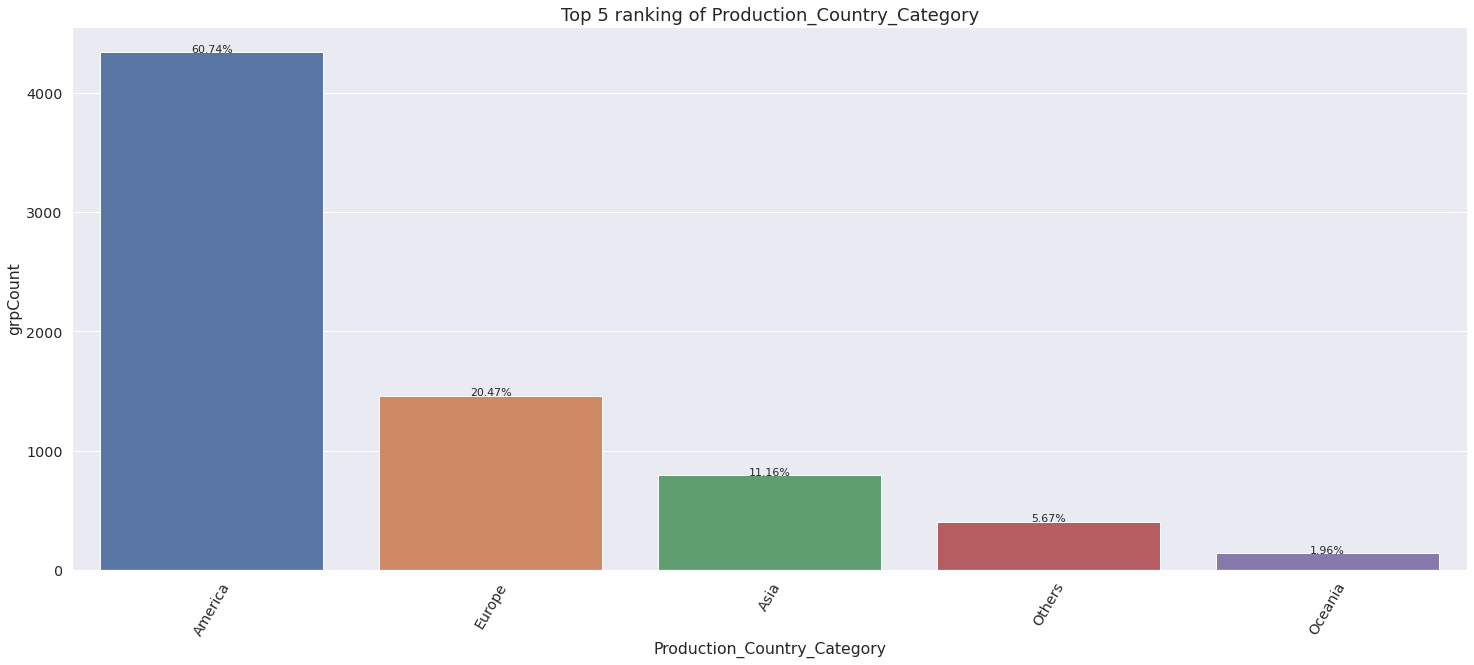

Total no. of Production_Country_Category : 5
Missing Data for Production_Country_Category : 0.00%


In [49]:
# Plot Production_Country details
plot_topmost_parm(source_df=partial_dataset, col_name='Production_Country_Category', total_items=len(partial_dataset), display_topmost=5, text_padding = 0.1)

In [50]:
#Remove production country as no longer needed
partial_dataset = partial_dataset.drop(columns = ['Production_Country'])
partial_dataset.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity,Production_Country_Category
0,252.917,181.0,2797.800564,356.0,8.3,18049,34.160,America
1,91.015,162.0,2787.965087,237.0,7.5,23336,13.223,America
2,71.200,194.0,2187.463944,200.0,7.9,19132,18.830,America
3,66.810,136.0,2068.223624,245.0,7.4,15758,15.398,America
4,307.301,149.0,2046.239637,300.0,8.3,21715,34.160,America


Recommendations:

Could replace each category with a learnable, low-dimensional vector called an embedding.

Each category’s representation would be learned during training with representation learning.
Could explore with other Machine Learning models (eg. Support Vectore Machine, Neural Network) to observe if the performance metric (ie. accuracy) can be improved.

### Replacing of 0 with medians for selected features

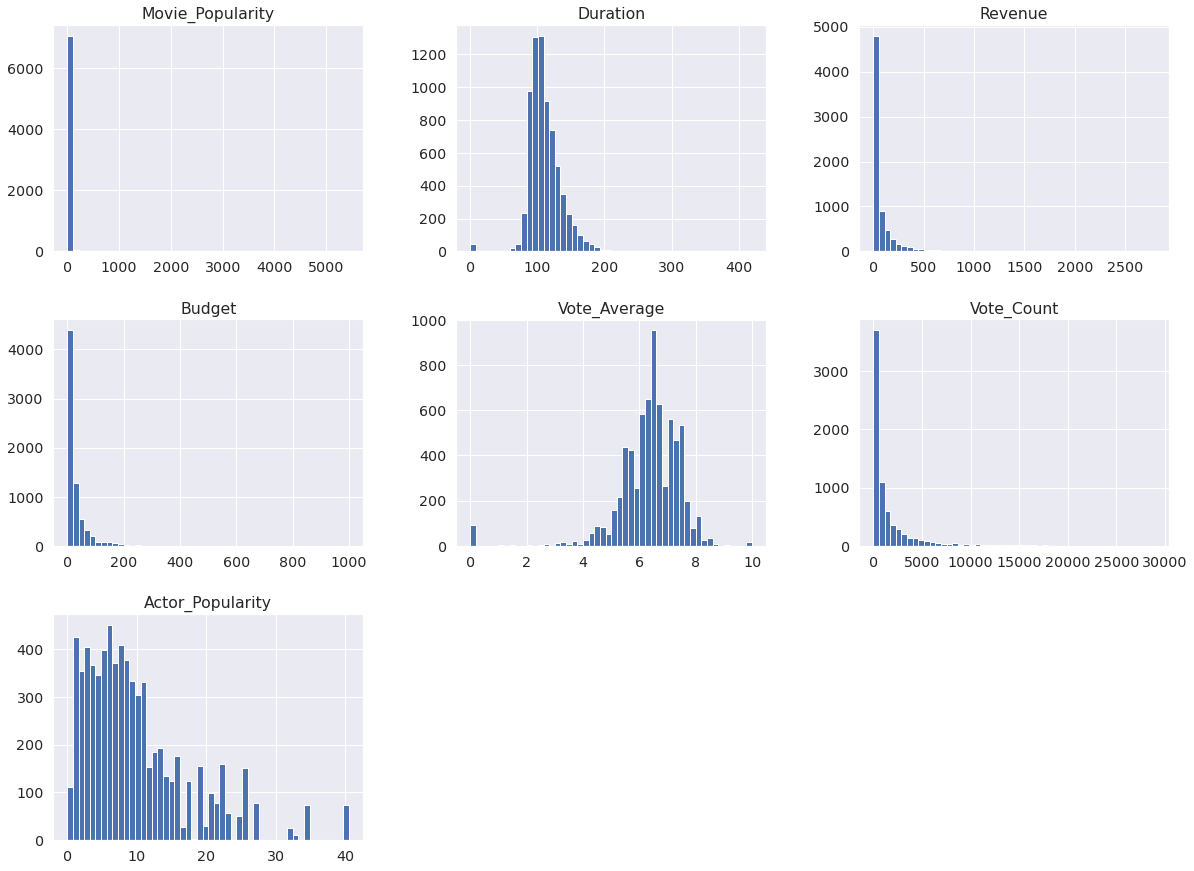

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
partial_dataset.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")

plt.show()

**Before replacing 0s with median**

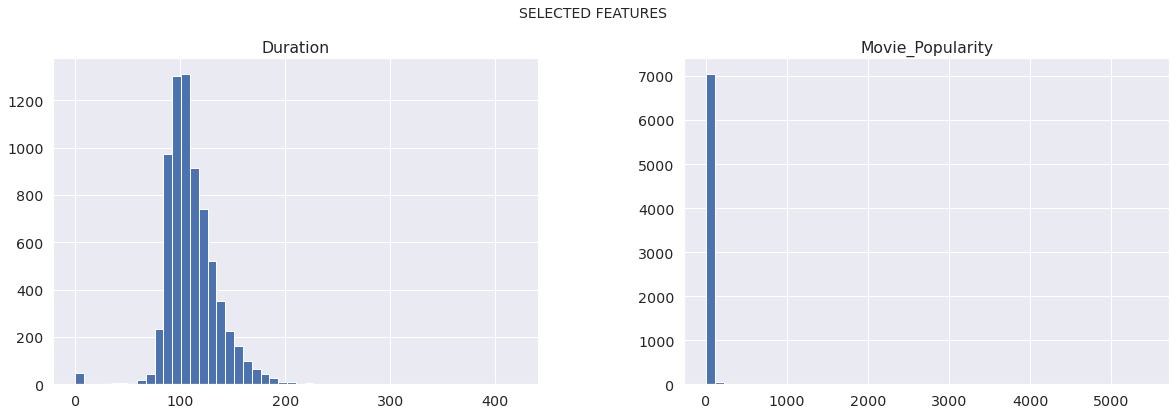

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Duration')
partial_dataset['Duration'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Movie_Popularity')
partial_dataset.hist('Movie_Popularity', bins=50, ax=axes[1])

plt.show()

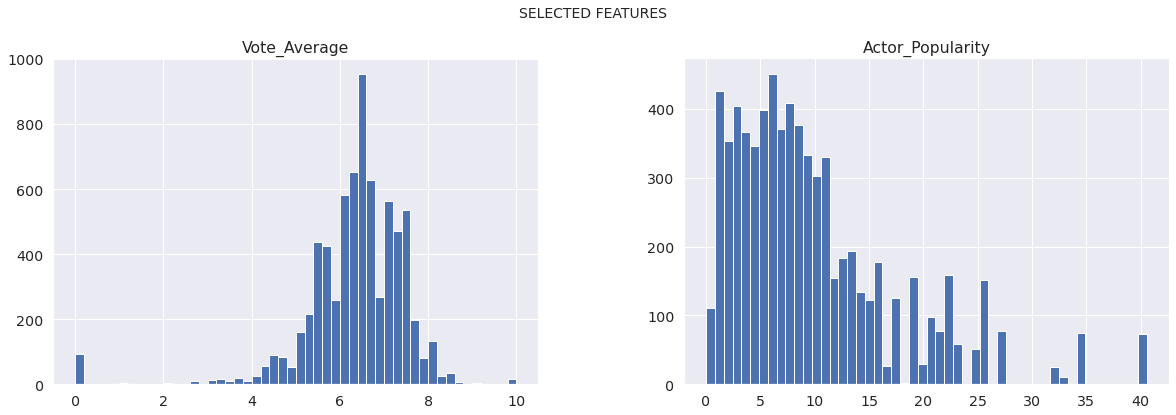

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Vote_Average')
partial_dataset['Vote_Average'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Actor_Popularity')
partial_dataset.hist('Actor_Popularity', bins=50, ax=axes[1])

plt.show()

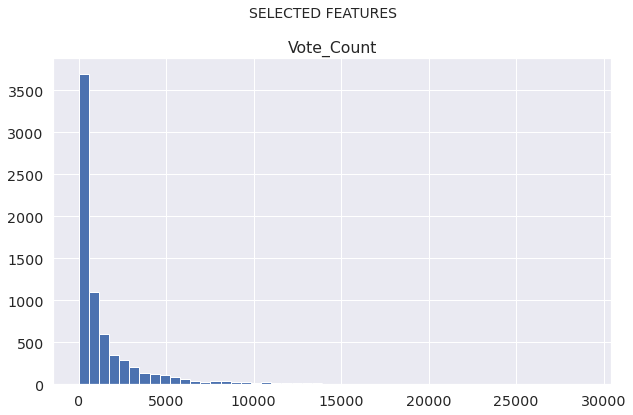

In [54]:
fig, axes = plt.subplots(figsize=(10, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes.set_title('Vote_Count')
partial_dataset['Vote_Count'].hist(bins=50)

plt.show()

** Transforming 0s to median values**

We only pick duration and vote_count to transform 0 values to median as the 0 values are outliers.

Median is chosen as average is affected by outliers and median serves as a better estimate.

In [55]:
# Note : Store the median values so that they can be used to replace missing values in the test set when you want to evaluate your system,
# and also once the system goes live to replace missing values in new data.
median_dict = {}
median_dict['Duration'] = partial_dataset['Duration'].median()
median_dict['Movie_Popularity'] = partial_dataset['Movie_Popularity'].median()
median_dict['Vote_Average'] = partial_dataset['Vote_Average'].median()
median_dict['Actor_Popularity'] = partial_dataset['Actor_Popularity'].median()
median_dict['Vote_Count'] = partial_dataset['Vote_Count'].median()

print('The stored median dictionary :\n', median_dict)



The stored median dictionary :
 {'Duration': 107.0, 'Movie_Popularity': 12.349, 'Vote_Average': 6.5, 'Actor_Popularity': 7.904, 'Vote_Count': 532.0}


In [56]:
# Before transformation no. of data with median values
print("\nBefore transformation (median values) :")
print("---------------------------------------")
print("No. of Duration with median ({}) : {}".\
      format(partial_dataset['Duration'].median(), (partial_dataset['Duration'] == partial_dataset['Duration'].median()).sum()))
print("No. of Movie_Popularity with median ({}) : {}".\
       format(partial_dataset['Movie_Popularity'].median(), (partial_dataset['Movie_Popularity'] == partial_dataset['Movie_Popularity'].median()).sum()))
print("No. of Vote_Average with median ({}) : {}".\
      format(partial_dataset['Vote_Average'].median(), (partial_dataset['Vote_Average'] == partial_dataset['Vote_Average'].median()).sum()))
print("No. of Actor_Popularity with median ({}) : {}".\
      format(partial_dataset['Actor_Popularity'].median(), (partial_dataset['Actor_Popularity'] == partial_dataset['Actor_Popularity'].median()).sum()))
print("No. of Vote_Count with median ({}) : {}".\
      format(partial_dataset['Vote_Count'].median(), (partial_dataset['Vote_Count'] == partial_dataset['Vote_Count'].median()).sum()))



Before transformation (median values) :
---------------------------------------
No. of Duration with median (107.0) : 142
No. of Movie_Popularity with median (12.349) : 1
No. of Vote_Average with median (6.5) : 311
No. of Actor_Popularity with median (7.904) : 5
No. of Vote_Count with median (532.0) : 6


**Based on domain knowledge, hist plots and previous no.s we can tell how many values are approximately median. Hence those with 0 as outliers should be changed to median**.

Changing to median instead of average as average is affected by outliers and median would provide a better estimate


In [57]:
# Replace zero values with median
partial_dataset['Duration'] = partial_dataset['Duration'].replace(0, partial_dataset['Duration'].median())
partial_dataset['Vote_Average'] = partial_dataset['Vote_Average'].replace(0, partial_dataset['Vote_Average'].median())


print("\nAfter transformation (median values) :")
print("----------------------------------------")
print("No. of Duration with median ({}) : {}".\
      format(partial_dataset['Duration'].median(), (partial_dataset['Duration'] == partial_dataset['Duration'].median()).sum()))
print("No. of Vote_Average with median ({}) : {}".\
      format(partial_dataset['Vote_Average'].median(), (partial_dataset['Vote_Average'] == partial_dataset['Vote_Average'].median()).sum()))

# Note : The minimum values are no longer zero
print("\nNew statistics after transformation :")
print("-------------------------------------")
partial_dataset.Duration.describe(), partial_dataset.Vote_Average.describe()


After transformation (median values) :
----------------------------------------
No. of Duration with median (107.0) : 188
No. of Vote_Average with median (6.5) : 403

New statistics after transformation :
-------------------------------------


(count    7136.000000
 mean      111.373038
 std        23.140020
 min         2.000000
 25%        96.000000
 50%       107.000000
 75%       122.250000
 max       420.000000
 Name: Duration, dtype: float64, count    7139.000000
 mean        6.429332
 std         0.925711
 min         0.800000
 25%         5.900000
 50%         6.500000
 75%         7.000000
 max        10.000000
 Name: Vote_Average, dtype: float64)

**After changing appropriate values to 0**

Only thing left is to use imputer for missing values

In [58]:
numeric_feature_count = 0
non_numeric_feature_count = 0

for col in partial_dataset.columns:
  if (partial_dataset[col].dtypes == 'int64') or (partial_dataset[col].dtypes == 'float64'):
    numeric_feature_count += 1
    print("Numeric feature No. {} and name : {}".format(numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}, Median values : {}".\
      format(partial_dataset[col].isnull().sum(), (partial_dataset[col] == 0).sum(),
             (partial_dataset[col] == partial_dataset[col].median()).sum()))
    print("-" * 70)
    print()
  else:
    non_numeric_feature_count += 1
    print("Non-numeric feature No. {} and name : {}".format(non_numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}".\
      format(partial_dataset[col].isnull().sum(), (partial_dataset[col] == 0).sum()))
    print("-" * 50)
    print()

print("Total No. of Numeric features {} and Non-numeric features : {}".format(numeric_feature_count, non_numeric_feature_count))

Numeric feature No. 1 and name : Movie_Popularity
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 2 and name : Duration
No. of Missing values : 3, Zero values : 0, Median values : 188
----------------------------------------------------------------------

Numeric feature No. 3 and name : Revenue
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 4 and name : Budget
No. of Missing values : 0, Zero values : 0, Median values : 73
----------------------------------------------------------------------

Numeric feature No. 5 and name : Vote_Average
No. of Missing values : 0, Zero values : 0, Median values : 403
----------------------------------------------------------------------

Numeric feature No. 6 and name : Vote_Count
No. of Missing values : 0, Zero values : 92, Median values : 6

**Only left with duration with null values which will be imputed later in pipeline**

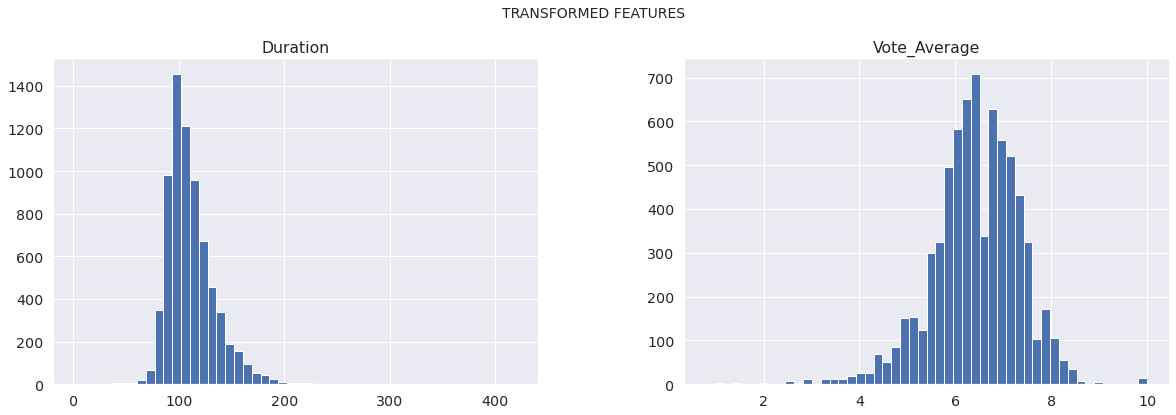

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Transformed Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Duration')
partial_dataset['Duration'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Vote_Average')
partial_dataset.hist('Vote_Average', bins=50, ax=axes[1])

plt.show()

## Section 3: Data Preprocessing
1. Use of simple imputer (For filling of missing values with median)
2. Use of one hot encoding for categorical variables (Production Countries)
3. Use of **standard scaler**
Standard scaler helps as most values are already gaussian and would scale all features to the same scale for greater accuracy

**Standard scaler helps scale Budget in millions and vote count in 1000s to same scale for greater accuracy**

In [60]:
#Imports for preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#Imports for Linear Regression model:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Imports for Decison Tree Regressor model:
from sklearn.tree import DecisionTreeRegressor

#Imports for Random Forest Regressor model:
from sklearn.ensemble import RandomForestRegressor

#Imports for SVM:
from sklearn.svm import SVR

#Imports for display of Decision Tree
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.metrics import r2_score
from IPython.display import SVG
from graphviz import Source
from IPython.display import display


In [61]:
numeric_data = partial_dataset.drop(columns = ['Production_Country_Category'])

numeric_data.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,252.917,181.0,2797.800564,356.0,8.3,18049,34.160
1,91.015,162.0,2787.965087,237.0,7.5,23336,13.223
2,71.200,194.0,2187.463944,200.0,7.9,19132,18.830
3,66.810,136.0,2068.223624,245.0,7.4,15758,15.398
4,307.301,149.0,2046.239637,300.0,8.3,21715,34.160


In [62]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7139 non-null   float64
 1   Duration          7136 non-null   float64
 2   Revenue           7139 non-null   float64
 3   Budget            7139 non-null   float64
 4   Vote_Average      7139 non-null   float64
 5   Vote_Count        7139 non-null   int64  
 6   Actor_Popularity  7139 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 390.5 KB


### Testing out imputer

In [63]:
imputer = SimpleImputer(strategy="median")

In [64]:
imputer.fit(numeric_data)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [65]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7139 non-null   float64
 1   Duration          7136 non-null   float64
 2   Revenue           7139 non-null   float64
 3   Budget            7139 non-null   float64
 4   Vote_Average      7139 non-null   float64
 5   Vote_Count        7139 non-null   int64  
 6   Actor_Popularity  7139 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 390.5 KB


In [66]:
imputer.statistics_

array([ 12.349 , 107.    ,  23.3551,  14.    ,   6.5   , 532.    ,
         7.904 ])

In [67]:
X = imputer.transform(numeric_data)
numeric_data_imputed = pd.DataFrame(X, columns=numeric_data.columns, index=numeric_data.index)

numeric_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7139 non-null   float64
 1   Duration          7139 non-null   float64
 2   Revenue           7139 non-null   float64
 3   Budget            7139 non-null   float64
 4   Vote_Average      7139 non-null   float64
 5   Vote_Count        7139 non-null   float64
 6   Actor_Popularity  7139 non-null   float64
dtypes: float64(7)
memory usage: 390.5 KB


### Testing out 1 hot encoder
On Production_Country_Cat

In [68]:
cat_encoder = OneHotEncoder()

production_country_cat_1hot = cat_encoder.fit_transform(partial_dataset['Production_Country_Category'].values.reshape(-1, 1))

production_country_cat_1hot

<7139x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7139 stored elements in Compressed Sparse Row format>

In [69]:
production_country_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [70]:
print(production_country_cat_1hot[4532:4538].toarray())
print()
print(partial_dataset['Production_Country_Category'][4532:4538])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

4532    America
4533       Asia
4534       Asia
4535     Europe
4536       Asia
4537    America
Name: Production_Country_Category, dtype: object


In [71]:
cat_encoder.categories_

[array(['America', 'Asia', 'Europe', 'Oceania', 'Others'], dtype=object)]

### Machine Learning Pipeline

In [72]:
partial_dataset.dtypes

Movie_Popularity               float64
Duration                       float64
Revenue                        float64
Budget                         float64
Vote_Average                   float64
Vote_Count                       int64
Actor_Popularity               float64
Production_Country_Category     object
dtype: object

In [73]:
partial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7139 entries, 0 to 7138
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Movie_Popularity             7139 non-null   float64
 1   Duration                     7136 non-null   float64
 2   Revenue                      7139 non-null   float64
 3   Budget                       7139 non-null   float64
 4   Vote_Average                 7139 non-null   float64
 5   Vote_Count                   7139 non-null   int64  
 6   Actor_Popularity             7139 non-null   float64
 7   Production_Country_Category  7139 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 446.3+ KB


In [74]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [75]:
#Scaling only predictors/features
numeric_data_new = numeric_data.drop(columns = ['Revenue'])
numeric_data_new

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,252.917,181.0,356.000,8.3,18049,34.160
1,91.015,162.0,237.000,7.5,23336,13.223
2,71.200,194.0,200.000,7.9,19132,18.830
3,66.810,136.0,245.000,7.4,15758,15.398
4,307.301,149.0,300.000,8.3,21715,34.160
...,...,...,...,...,...,...
7134,7.465,100.0,2.500,6.8,32,5.114
7135,2.175,104.0,0.344,8.1,19,1.400
7136,10.741,92.0,4.000,6.2,100,12.792
7137,0.600,126.0,0.210,6.5,0,0.600


In [76]:
X = partial_dataset.drop(columns = ['Revenue']) #All your predictors
num_attribs = list(numeric_data_new)
cat_attribs = ["Production_Country_Category"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_transformed = full_pipeline.fit_transform(X)
X_transformed

array([[ 2.77276125,  3.00984141,  7.69859675, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84455103,  2.18852915,  4.90128601, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6085596 ,  3.57179191,  4.03153394, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.11149118, -0.83735813, -0.5758014 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.23226783,  0.63235855, -0.66489222, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22401438, -0.18895371, -0.66747797, ...,  0.        ,
         0.        ,  0.        ]])

In [77]:
#7 numeric columns with 5 one hot-encoded columns for 'Production_Country_Category'
X_transformed.shape

(7139, 11)

In [78]:
partial_dataset.dtypes

Movie_Popularity               float64
Duration                       float64
Revenue                        float64
Budget                         float64
Vote_Average                   float64
Vote_Count                       int64
Actor_Popularity               float64
Production_Country_Category     object
dtype: object

In [79]:
X_transformed_df = pd.DataFrame(X_transformed, columns = ['Movie_Popularity', 'Duration', 'Budget', 'Vote_Average', 'Vote_Count',
                                                      'Actor_Popularity', 'PCC_OHE_1','PCC_OHE_2','PCC_OHE_3', 'PCC_OHE_4', 'PCC_OHE_5'])

In [80]:
# All scaled predictors/features
X_transformed_df

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
0,2.772761,3.009841,7.698597,2.020933,6.028329,3.132574,1.0,0.0,0.0,0.0,0.0
1,0.844551,2.188529,4.901286,1.156672,7.961475,0.426919,1.0,0.0,0.0,0.0,0.0
2,0.608560,3.571792,4.031534,1.588802,6.424319,1.151503,1.0,0.0,0.0,0.0,0.0
3,0.556276,1.064628,5.089341,1.048639,5.190645,0.707991,1.0,0.0,0.0,0.0,0.0
4,3.420460,1.626579,6.382215,2.020933,7.368770,3.132574,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7134,-0.150507,-0.491542,-0.611062,0.400443,-0.559430,-0.620994,1.0,0.0,0.0,0.0,0.0
7135,-0.213510,-0.318635,-0.661742,1.804868,-0.564184,-1.100948,0.0,0.0,0.0,0.0,1.0
7136,-0.111491,-0.837358,-0.575801,-0.247753,-0.534567,0.371222,1.0,0.0,0.0,0.0,0.0
7137,-0.232268,0.632359,-0.664892,0.076345,-0.571131,-1.204331,0.0,1.0,0.0,0.0,0.0


In [81]:
X_transformed_df.describe()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
count,7.139000e+03,7.139000e+03,7.139000e+03,7.139000e+03,7.139000e+03,7.139000e+03,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000
mean,-3.183046e-16,2.303763e-16,4.138260e-17,5.818943e-15,5.415350e-16,8.972605e-16,0.607368,0.111640,0.204651,0.019611,0.056731
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,0.488370,0.314945,0.403474,0.138668,0.231343
min,-2.322678e-01,-4.727785e+00,-6.698286e-01,-6.081519e+00,-5.711307e-01,-1.281868e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.421409e-01,-6.644503e-01,-5.758014e-01,-5.718514e-01,-5.305445e-01,-7.117120e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-9.234033e-02,-1.889537e-01,-3.407333e-01,7.634472e-02,-3.766095e-01,-2.604465e-01,1.000000,0.000000,0.000000,0.000000,0.000000
75%,-9.829670e-03,4.594507e-01,1.529098e-01,6.165082e-01,4.790004e-02,4.111533e-01,1.000000,0.000000,0.000000,0.000000,0.000000
max,6.456640e+01,1.334109e+01,2.283698e+01,3.857489e+00,1.002662e+01,3.964675e+00,1.000000,1.000000,1.000000,1.000000,1.000000


## Section 4: Machine Learning Models

1. **Linear Regression**
2. **Decision Tree Regressor**
3. **Random Forest Regressor**
4. **SVM, Linear kernel, Polynomial kernel, rbf kernel**

In [82]:
X_train, X_test = train_test_split(X_transformed_df, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(5711, 1428)

In [83]:
Revenue = partial_dataset['Revenue'].copy() # Response variable

y_train, y_test = train_test_split(Revenue, test_size=0.2, random_state=42)
len(y_train), len(y_test)

(5711, 1428)

In [84]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
4840,-0.175280,2.707253,-0.470021,0.724541,-0.547364,-0.897930,0.0,1.0,0.0,0.0,0.0
4215,-0.130440,-0.361862,-0.654663,1.264704,-0.352477,-0.584810,0.0,0.0,1.0,0.0,0.0
6552,-0.225813,-1.139947,-0.611062,-2.516440,-0.568571,-1.100948,1.0,0.0,0.0,0.0,0.0
2799,0.055900,-0.837358,-0.575801,0.400443,1.143361,0.974977,0.0,0.0,1.0,0.0,0.0
1345,-0.021370,-1.096720,1.680853,-0.031688,-0.397085,-0.039208,0.0,0.0,1.0,0.0,0.0


In [85]:
X_test.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
3027,-0.130809,0.372997,-0.458267,0.292410,-0.537857,-0.476258,1.0,0.0,0.0,0.0,0.0
5272,-0.165990,-0.145727,-0.458267,-0.247753,-0.554677,1.169724,1.0,0.0,0.0,0.0,0.0
5790,-0.079895,-0.750904,0.123439,0.832574,-0.378803,-1.128603,0.0,0.0,1.0,0.0,0.0
696,0.004569,-0.232181,0.505512,0.400443,0.955056,2.063209,0.0,0.0,1.0,0.0,0.0
1423,-0.084111,0.718812,0.975648,0.184377,0.217558,1.151503,1.0,0.0,0.0,0.0,0.0


In [86]:
y_train.describe()

count    5711.000000
mean       83.231139
std       171.390624
min         0.350000
25%         5.408198
50%        23.057115
75%        83.544915
max      2797.800564
Name: Revenue, dtype: float64

#### Linear Regresion Model



In [87]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
# let's try the full preprocessing pipeline on a few training instances
# These features has already been scaled previously before train test split

some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Predictions :\n", lin_reg.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Predictions :
 [  6.80143348  -6.77903778  47.25951318 180.45263983 166.01461965
  93.89495036 -11.28979222  96.80759752 241.63247757  82.07243752]

Labels :
 [34.57378, 6.045657, 3.445, 222.8096, 113.280098, 124.827316, 34.251525, 207.515725, 100.546153, 116.476887]


In [89]:
y_train_pred = lin_reg.predict(X_train)

In [90]:
y_test_pred = lin_reg.predict(X_test)

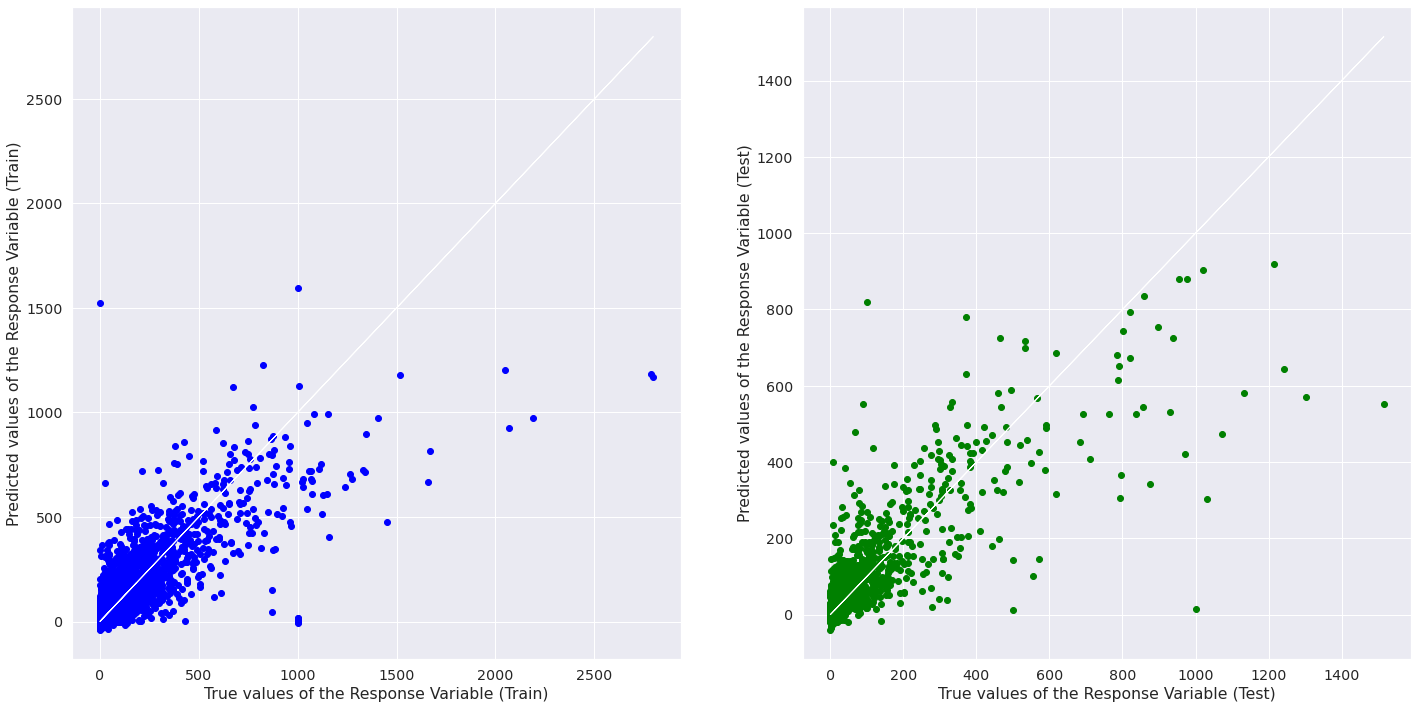

In [91]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit Model**

In [92]:
# Check the Goodness of Fit (on Train Data)
print("Linear Regression \n")
print("Goodness of Fit of Model, \tTrain Dataset")
print("Explained Variance (R^2) \t:", lin_reg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Linear Regression (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", lin_reg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Linear Regression (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Linear Regression 

Goodness of Fit of Model, 	Train Dataset
Explained Variance (R^2) 	: 0.6762842772853428
Mean Squared Error (MSE) 	: 9507.40208479427
Linear Regression (RMSE) 	: 97.505907948156

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6682425194120734
Mean Squared Error (MSE) 	: 9247.493573916086
Linear Regression (RMSE) 	: 96.16388913680689



#### DecisionTreeRegressor

**Decison Tree overfits really badly on train set hence predictions on test set are not as good as Linear Regression**

In [93]:
#Training 

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [94]:
y_train_pred = tree_reg.predict(X_train)

In [95]:
y_test_pred = tree_reg.predict(X_test)

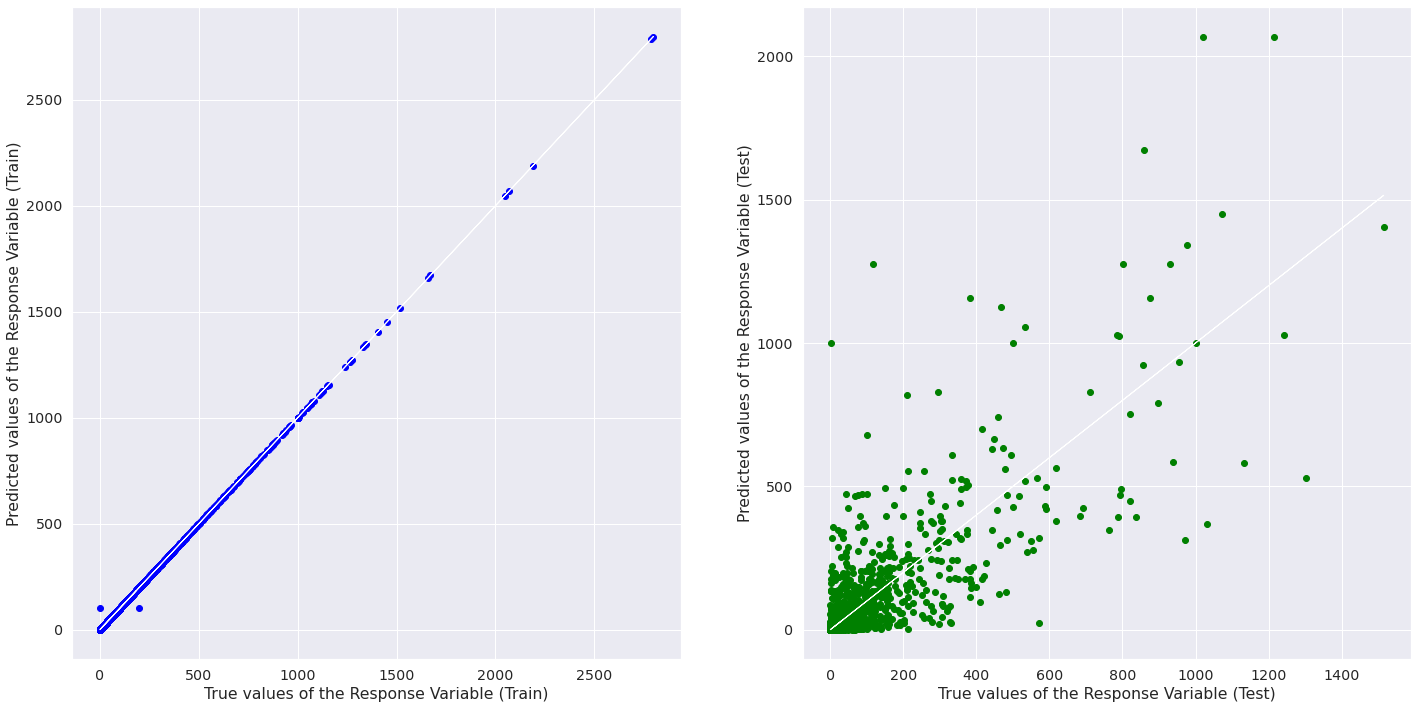

In [96]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

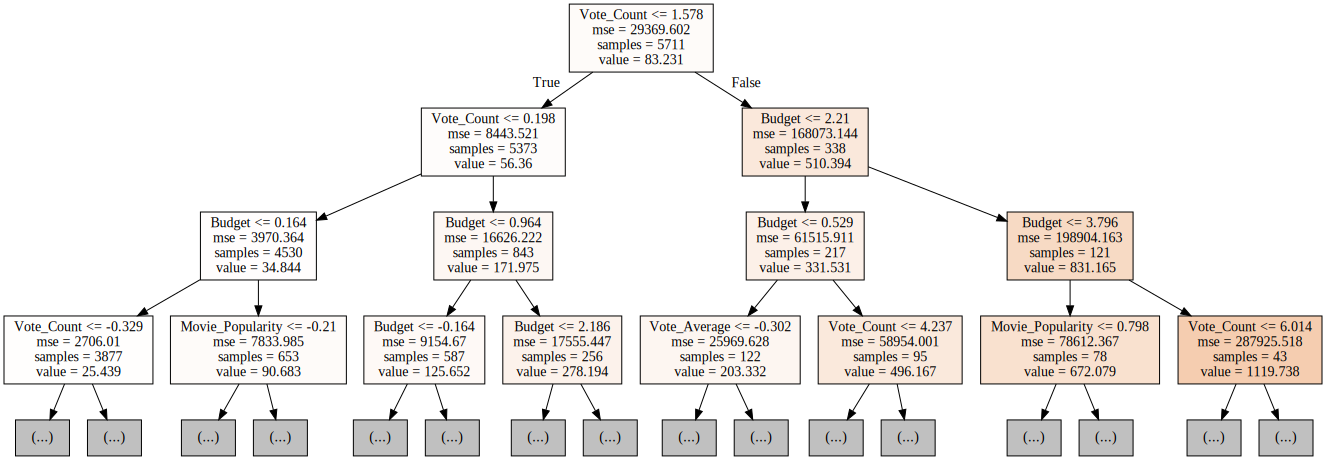

In [97]:
labels = X_train.columns
graph = Source(tree.export_graphviz(tree_reg ,feature_names = labels, class_names = y_train.unique(), max_depth = 3, filled = True))
display(SVG(graph.pipe(format='svg')))

**Goodness of fit**

In [98]:
# Check the Goodness of Fit (on Train Data)
print("Decision Tree \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Decision Tree Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Decision Tree Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Decision Tree 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 3.4670810716429528
Decision Tree Regressor (RMSE) 	: 1.8620099547647302

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 14408.361782878736
Decision Tree Regressor (RMSE) 	: 120.03483570563479



#### Ensemble Learning using Random Forest Regressor


**Best model**

In [99]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [100]:
y_train_pred = forest_reg.predict(X_train)

In [101]:
y_test_pred = forest_reg.predict(X_test)

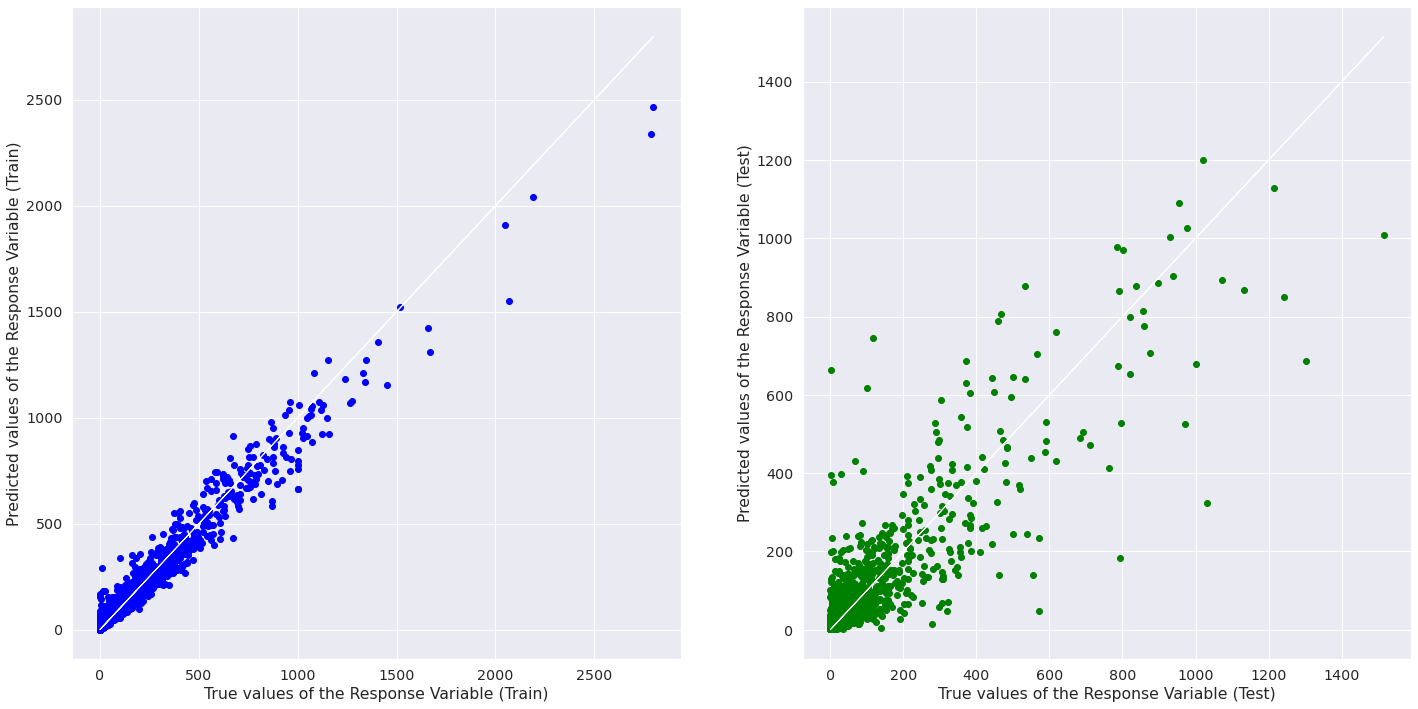

In [102]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [103]:
# Check the Goodness of Fit (on Train Data)
print("Random Forest Regressor \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Random Forest Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Random Forest Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Random Forest Regressor 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 1033.7149797800073
Random Forest Regressor (RMSE) 	: 32.151438222574235

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 6973.047077419698
Random Forest Regressor (RMSE) 	: 83.50477278227693



#### SVM Model

**Linear is the best**

In [104]:
#Training
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [105]:
y_train_pred = svm_reg.predict(X_train)

In [106]:
y_test_pred = svm_reg.predict(X_test)

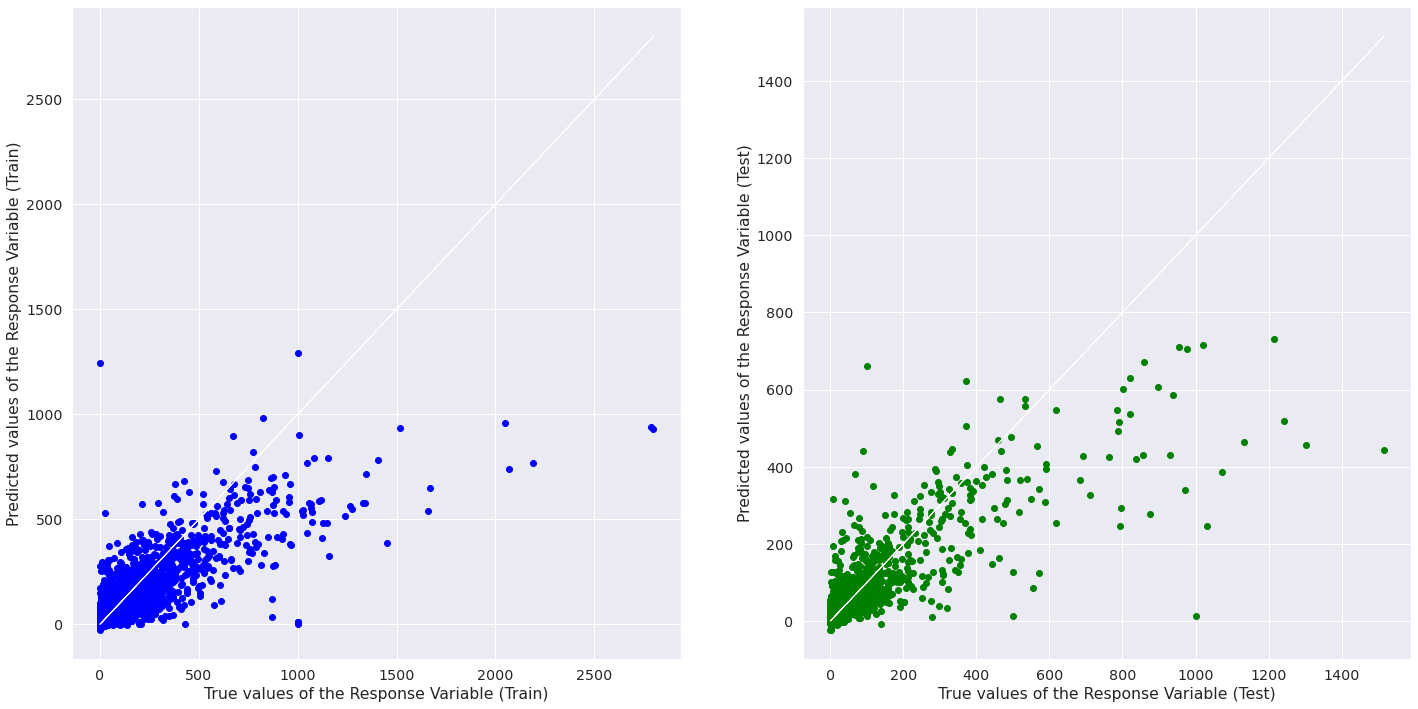

In [107]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [108]:
# Check the Goodness of Fit (on Train Data)
print("SVM Linear Kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM Linear Kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 10518.620108242496
SVM (RMSE) 	: 102.56032424013925

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 9963.08642504473
SVM (RMSE) 	: 99.81526148362649



**Trying a different kernel, polynomial kernel**

In [109]:
#Training
svm_reg = SVR(kernel="poly")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [110]:
y_train_pred = svm_reg.predict(X_train)

In [111]:
y_test_pred = svm_reg.predict(X_test)

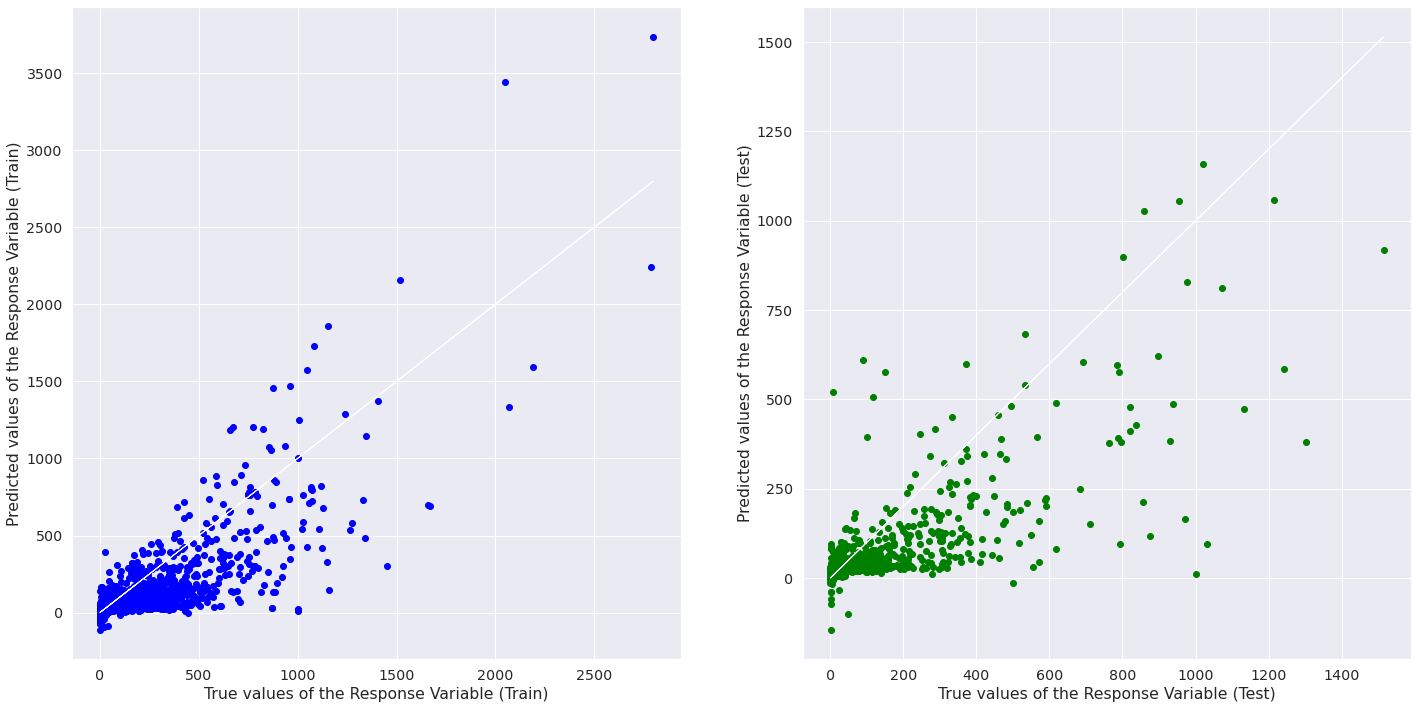

In [112]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [113]:
# Check the Goodness of Fit (on Train Data)
print("SVM Polynomial Kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM Polynomial Kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 11975.678900479357
SVM (RMSE) 	: 109.43344507269867

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 12974.530194926552
SVM (RMSE) 	: 113.90579526488787



**Trying rbf kernel**

In [114]:
#Training
svm_reg = SVR(kernel="rbf")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [115]:
y_train_pred = svm_reg.predict(X_train)

In [116]:
y_test_pred = svm_reg.predict(X_test)

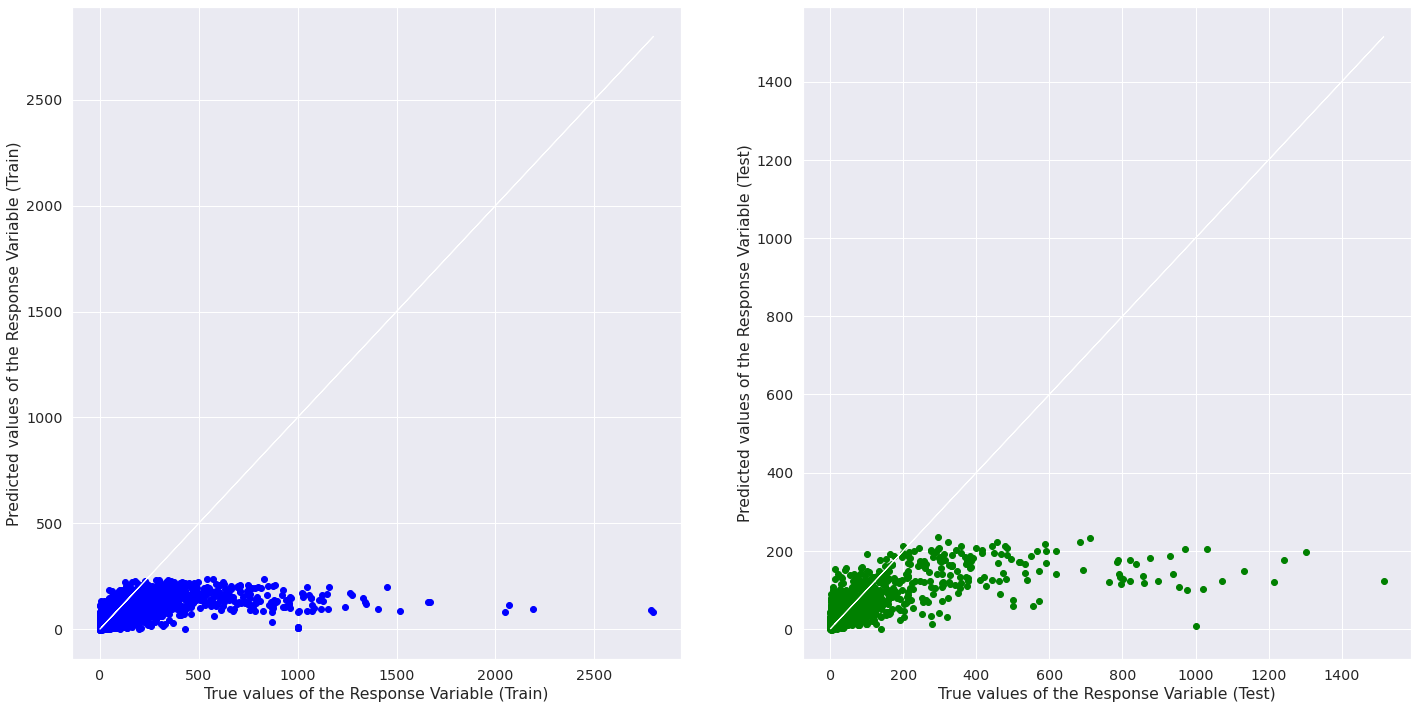

In [117]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [118]:
# Check the Goodness of Fit (on Train Data)
print("SVM rbf kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM rbf kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 22611.31365729163
SVM (RMSE) 	: 150.3705877400618

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 20334.159280554984
SVM (RMSE) 	: 142.59789367502938



## Section 5: Fine-tuning of Models and final model prediction
**(Better evaluation using cross-validation scores on test set)**

#### Comparison of Models (Testing out how CrossValidation works)

**Extra**

In [119]:
#Imports
from sklearn.model_selection import cross_val_score

In [120]:
def display_scores(scores):
    print("RMSE Scores: ", scores)
    print()
    print("Average RMSE: ", scores.mean())
    print()
    print("Standard deviation of RMSE: ", scores.std())

**Linear Regression Model Score**

In [121]:
lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

print("Linear Regression scores(Train) \n")
display_scores(lin_reg_rmse_scores)
print()
print(pd.Series(np.sqrt(-lin_reg_scores)).describe())

Linear Regression scores(Train) 

RMSE Scores:  [ 98.78829785  99.82796024  88.53440845  78.3753606  112.9647265
  69.4090536  113.99077735 104.62599657  99.56973092 112.94594495]

Average RMSE:  97.90322570316684

Standard deviation of RMSE:  14.301861647553062

count     10.000000
mean      97.903226
std       15.075486
min       69.409054
25%       91.097881
50%       99.698846
75%      110.865958
max      113.990777
dtype: float64


In [122]:
lin_reg_scores = cross_val_score(lin_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

print("Linear Regression scores(Test) \n")
display_scores(lin_reg_rmse_scores)
print()
print(pd.Series(np.sqrt(-lin_reg_scores)).describe())

Linear Regression scores(Test) 

RMSE Scores:  [ 69.68427222 106.08560125  84.87219053  77.3409664  103.1229499
 100.52591357  77.96304733 123.20252109 113.14352103 102.69221596]

Average RMSE:  95.86331992853903

Standard deviation of RMSE:  16.556729559586614

count     10.000000
mean      95.863320
std       17.452325
min       69.684272
25%       79.690333
50%      101.609065
75%      105.344938
max      123.202521
dtype: float64


**Decision Tree Regressor Score**

In [123]:
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Decision Tree Score(Train) \n ")
display_scores(tree_rmse_scores)

Decision Tree Score(Train) 
 
RMSE Scores:  [119.66834183 125.7345459  125.38940566  91.91382624 146.8426208
  90.27003223 123.03565998 123.33476913 123.53947609 126.28716686]

Average RMSE:  119.6015844721228

Standard deviation of RMSE:  15.893634145514028


In [124]:
scores = cross_val_score(tree_reg, X_test, y_test,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Decision Tree Score(Test) \n ")
display_scores(tree_rmse_scores)

Decision Tree Score(Test) 
 
RMSE Scores:  [133.51567092 116.39904064 131.98699336  94.39960844 137.57441907
  94.60026856 138.32627213 113.32650433 130.49383654 116.64536757]

Average RMSE:  120.72679815487427

Standard deviation of RMSE:  15.637117677397216


**Observation**

**Linear Regression model** performs better than Decision Tree Regressor model with the test set

**Reason**: Decision Tree Regressor model is overfitting badly that it perofrms worse than the Linear Regression model(shown in cross validations)

**Random Forest Regressor scores**

**Still Best Model**

In [125]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest Regressor score (Train) \n ")
display_scores(forest_rmse_scores)

Random Forest Regressor score (Train) 
 
RMSE Scores:  [ 92.52675415  90.32655339  91.02676539  66.34950074 100.00143824
  69.2466873   98.88519082  96.17225196  94.68309401  80.59734962]

Average RMSE:  87.98155856188028

Standard deviation of RMSE:  11.332535887523413


In [126]:
forest_scores = cross_val_score(forest_reg, X_test, y_test,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest Regressor score (Test)\n ")
display_scores(forest_rmse_scores)

Random Forest Regressor score (Test)
 
RMSE Scores:  [ 84.0066933  101.52801274  76.07605259  76.18381348  94.17311346
  88.96812143  82.20835654 109.03730408 119.56024812  82.08365886]

Average RMSE:  91.3825374603717

Standard deviation of RMSE:  13.829494044581553


**Observation**

**Random Forest Regressor** is performing the best among all models for both test set

**SVM scores**

In [127]:
svm_scores_rbf = cross_val_score(svm_reg, X_train, y_train,scoring="neg_mean_squared_error", cv=10)

svm_rbf_rmse_scores = np.sqrt(-svm_scores_rbf)
print("SVM scores (Train) \n")
display_scores(svm_rbf_rmse_scores)

SVM scores (Train) 

RMSE Scores:  [151.67417373 132.75681858 140.53986177 124.25189714 186.86039168
 100.11464874 194.17463798 167.34307253 153.5846863  143.4230947 ]

Average RMSE:  149.47232831545884

Standard deviation of RMSE:  26.842742063322095


In [128]:
svm_scores_rbf = cross_val_score(svm_reg, X_test, y_test,scoring="neg_mean_squared_error", cv=10)

svm_rbf_rmse_scores = np.sqrt(-svm_scores_rbf)
print("SVM scores (Test) \n")
display_scores(svm_rbf_rmse_scores)

SVM scores (Test) 

RMSE Scores:  [133.52686453 197.02817335 168.15284181 113.58784519 192.26418489
 117.5029643  160.4088708  197.51451856 137.34168192 165.65123111]

Average RMSE:  158.29791764642604

Standard deviation of RMSE:  30.105342320747962


#### Gridsearch to tune and pick best model

Comparing RMSE of test sets of all tuned models and picking the best

In [129]:
#Imports

from sklearn.model_selection import GridSearchCV

##### Linear Regression hyper paramater tuning and result


In [130]:
%%time

param_grid = [
    #Try true,false
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]},
  ]

lin_reg = LinearRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_LinearReg = GridSearchCV(lin_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_LinearReg.fit(X_train, y_train)

CPU times: user 707 ms, sys: 837 ms, total: 1.54 s
Wall time: 825 ms


In [131]:
grid_search_LinearReg.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [132]:
grid_search_LinearReg.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [133]:
cvres = grid_search_LinearReg.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

98.9373460669071 {'copy_X': True, 'fit_intercept': True, 'normalize': True}
98.94233092903652 {'copy_X': True, 'fit_intercept': True, 'normalize': False}
98.94233092903652 {'copy_X': True, 'fit_intercept': False, 'normalize': True}
98.94233092903652 {'copy_X': True, 'fit_intercept': False, 'normalize': False}
98.9373460669071 {'copy_X': False, 'fit_intercept': True, 'normalize': True}
98.94233092903652 {'copy_X': False, 'fit_intercept': True, 'normalize': False}
98.94233092903652 {'copy_X': False, 'fit_intercept': False, 'normalize': True}
98.94233092903652 {'copy_X': False, 'fit_intercept': False, 'normalize': False}


In [134]:
pd.DataFrame(grid_search_LinearReg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.012525,0.002888,0.002151,0.001214,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10943.474093,-9914.131315,-12750.047516,-9788.598447,2665.856846,1,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.350036e+03,-9483.069017,-9.221963e+03,-9.493511e+03,2.868251e+02
1,0.004151,0.000059,0.001581,0.000888,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.349700e+03,-9483.069017,-9.222044e+03,-9.493485e+03,2.868343e+02
2,0.005534,0.002951,0.001290,0.000034,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.349700e+03,-9483.069017,-9.222044e+03,-9.493485e+03,2.868343e+02
3,0.005402,0.002411,0.001313,0.000054,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.349700e+03,-9483.069017,-9.222044e+03,-9.493485e+03,2.868343e+02
4,0.004934,0.001080,0.001578,0.000876,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'norm...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10943.474093,-9914.131315,-12750.047516,-9788.598447,2665.856846,1,-28859.514710,-29461.516638,-29043.540937,-29644.712001,-27645.445048,-30300.227792,-27165.270689,-4.171591e+30,-28762.409407,-5.170844e+29,-4.688675e+29,1.243832e+30
5,0.004776,0.002069,0.001355,0.000124,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'norm...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9497.627736,-9468.975685,-9736.809930,-9891.159449,-9174.735282,-10034.231164,-9159.828119,-9.378963e+03,-9496.938768,-9.231117e+03,-9.507039e+03,2.834487e+02
6,0.003815,0.000475,0.001265,0.000039,False,False,True,"{'copy_X': False, 'fit_intercept': False, 'nor...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.349700e+03,-9483.069017,-9.222044e+03,-9.493485e+03,2.868343e+02
7,0.009438,0.005699,0.001515,0.000359,False,False,False,"{'copy_X': False, 'fit_intercept': False, 'nor...",-9759.127792,-9965.621646,-7838.341479,-6142.697149,-12761.029434,-4817.616722,-12993.89732,-10946.599158,-9914.131315,-12756.786480,-9789.584850,2666.741551,3,-9484.619609,-9461.475269,-9713.906550,-9884.181498,-9161.603900,-10033.367347,-9140.886836,-9.349700e+03,-9483.069017,-9.222044e+03,-9.493485e+03,2.868343e+02


In [135]:
# Using tuned linear reg for predictions for new data
final_model_LinearReg = grid_search_LinearReg.best_estimator_


final_test_LinearReg_pred = final_model_LinearReg.predict(X_test) #(test set)

final_mse_LinearReg = mean_squared_error(y_test, final_test_LinearReg_pred) # y_test
final_rmse_LinearReg = np.sqrt(final_mse_LinearReg)

print("Linear Regression:\n")
print("root mean squared error of test is: ", final_rmse_LinearReg)

Linear Regression:

root mean squared error of test is:  96.16388913680687


##### Decision Tree hyperparameter


In [136]:
%%time


param_grid = [
              { 'criterion': ['mse', 'friedman_mse', 'mae'],
                'splitter': ['best','random'],
                'max_depth': [2,4,6,8,10,12],
                'max_features': [2, 4, 6, 8, 10]
              }
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_DecisionTree = GridSearchCV(tree_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_DecisionTree.fit(X_train, y_train)

CPU times: user 4min 3s, sys: 252 ms, total: 4min 3s
Wall time: 4min 2s


In [137]:
grid_search_DecisionTree.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 6,
 'max_features': 10,
 'splitter': 'best'}

In [138]:
grid_search_DecisionTree.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=6,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [139]:
cvres = grid_search_DecisionTree.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

155.87320687506357 {'criterion': 'mse', 'max_depth': 2, 'max_features': 2, 'splitter': 'best'}
171.33128829051384 {'criterion': 'mse', 'max_depth': 2, 'max_features': 2, 'splitter': 'random'}
143.47831790304176 {'criterion': 'mse', 'max_depth': 2, 'max_features': 4, 'splitter': 'best'}
167.1919767812928 {'criterion': 'mse', 'max_depth': 2, 'max_features': 4, 'splitter': 'random'}
134.8125332404135 {'criterion': 'mse', 'max_depth': 2, 'max_features': 6, 'splitter': 'best'}
128.7204914538337 {'criterion': 'mse', 'max_depth': 2, 'max_features': 6, 'splitter': 'random'}
134.61414087746613 {'criterion': 'mse', 'max_depth': 2, 'max_features': 8, 'splitter': 'best'}
126.78158711929477 {'criterion': 'mse', 'max_depth': 2, 'max_features': 8, 'splitter': 'random'}
116.12640231643209 {'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'splitter': 'best'}
117.77046575652477 {'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'splitter': 'random'}
136.7949993699104 {'criterion': 'mse', 'm

In [140]:
pd.DataFrame(grid_search_DecisionTree.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004728,0.001594,0.001636,0.001141,mse,2,2,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-27149.545825,-16798.141594,-20229.439755,-14938.586499,-38338.682879,-13378.483130,-35684.384594,-27067.257738,-23858.033509,-25522.010692,-24296.456622,7898.847442,161,-27623.562445,-23582.769700,-23199.436379,-23777.764218,-26111.416442,-23970.026122,-21484.206616,-22449.850904,-22795.785359,-27546.900074,-24254.171826,2014.207860
1,0.002131,0.000175,0.000870,0.000053,mse,2,2,random,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-29050.447555,-23678.954472,-27185.789263,-21921.458312,-39860.659546,-15835.382951,-44867.960561,-34210.473160,-30253.343976,-26679.633677,-29354.410347,8109.342503,176,-27577.472340,-29830.860487,-29440.641994,-28326.096259,-28032.230763,-29002.983081,-27480.110162,-28662.180426,-28997.740959,-29496.402890,-28684.671936,772.987849
2,0.003323,0.000105,0.000953,0.000198,mse,2,4,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-22774.580697,-15756.667221,-24858.325849,-15545.208581,-27549.196126,-11823.532706,-26174.205697,-22617.699968,-20867.967047,-17892.893191,-20586.027708,4896.220967,155,-19321.773701,-20299.983451,-19390.198124,-20637.318650,-19002.850580,-20853.054046,-18831.758724,-19583.999167,-19778.834655,-19756.175490,-19745.594659,636.318367
3,0.002183,0.000083,0.000869,0.000046,mse,2,4,random,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-27244.978315,-22604.122636,-26560.836155,-19140.560904,-36911.980399,-15030.297552,-43006.701973,-34863.465942,-29752.164440,-24416.462683,-27953.157100,8037.917183,172,-27545.316168,-28061.812026,-27630.402008,-28453.842735,-26484.040374,-28906.771816,-25820.095543,-26579.923093,-27276.955770,-27859.411685,-27461.857122,899.371172
4,0.004759,0.000526,0.000945,0.000133,mse,2,6,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-20651.331663,-14423.609933,-19916.904103,-11449.063819,-26312.988586,-10008.253109,-28554.334069,-18507.285862,-15803.066563,-16117.353480,-18174.419119,5648.904053,145,-16724.082794,-17310.174958,-16869.949169,-17696.024525,-16090.681509,-17826.928875,-16090.896172,-16888.758693,-17160.904061,-17131.762803,-16979.016356,553.359419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.381921,0.010379,0.001505,0.000127,mae,12,6,random,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-19901.629713,-14294.448030,-17994.180904,-6690.365653,-16017.832659,-8766.095802,-17098.836775,-11539.026161,-12011.120287,-10765.376044,-13507.891203,4042.542215,84,-3520.147073,-4504.585026,-3436.906977,-3886.139899,-3015.746105,-4565.731895,-3706.242750,-4911.656641,-3961.067191,-4215.269831,-3972.349339,553.293185
176,0.628470,0.006916,0.001520,0.000125,mae,12,8,best,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-12454.798455,-8419.179807,-13534.568090,-8411.263729,-13322.540072,-6227.869400,-17096.217743,-12007.198166,-13808.660931,-17355.956439,-12263.825283,3472.212826,54,-1456.607625,-1328.977709,-1221.060889,-1339.180348,-1499.005216,-1604.873802,-1342.863355,-1547.870628,-1365.426155,-1717.855518,-1442.372124,143.229174
177,0.467891,0.028320,0.001418,0.000038,mae,12,8,random,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-15452.851627,-14119.061156,-14244.260234,-7862.666730,-9881.463892,-10527.800297,-16675.347644,-14525.729810,-12787.056

In [141]:
# Using tuned Decision Tree for predictions for new data
final_model_DecisionTree = grid_search_DecisionTree.best_estimator_


final_test_DecisionTree_pred = final_model_DecisionTree.predict(X_test) #(test set)

final_mse_DecisionTree = mean_squared_error(y_test, final_test_DecisionTree_pred) # y_test
final_rmse_DecisionTree = np.sqrt(final_mse_DecisionTree)

print("Decision Tree: \n")
print("root mean squared error of test is: ", final_rmse_DecisionTree)

Decision Tree: 

root mean squared error of test is:  110.64055889339693


##### Random Forest hyperparameter
**Best**


In [142]:
%%time

param_grid = [
    # combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8, 10], 
     'bootstrap': [True,False]
     }, 
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_RandomForest = GridSearchCV(forest_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_RandomForest.fit(X_train, y_train)

CPU times: user 1min 41s, sys: 223 ms, total: 1min 41s
Wall time: 1min 41s


In [143]:
grid_search_RandomForest.best_params_

{'bootstrap': True, 'max_features': 4, 'n_estimators': 30}

In [144]:
grid_search_RandomForest.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [145]:
cvres = grid_search_RandomForest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

107.52181372932876 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
91.46592111065429 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
89.0547718348602 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
102.94682065680257 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
92.42886523942673 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
88.31889249485442 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
98.64911925338967 {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}
90.80986041937459 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
88.87824854628788 {'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
102.4012257008281 {'bootstrap': True, 'max_features': 8, 'n_estimators': 3}
92.59049820390317 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
89.26301342670611 {'bootstrap': True, 'max_features': 8, 'n_estimators': 30}
97.86894573006253 {'bootstrap': True, 'max_features': 10, 'n_estimators': 3}
91

In [146]:
pd.DataFrame(grid_search_RandomForest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.031249,0.016071,0.002418,0.000275,True,2,3,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-11305.713584,-10874.093299,-11017.506644,-7303.539327,-16595.479351,-9083.768369,-16090.184740,-9369.545094,-13224.600832,-10744.973036,-11560.940428,2814.080382,30,-2631.079234,-3025.137022,-3402.693666,-2941.692496,-2.933457e+03,-3366.324336,-2389.173840,-2499.154926,-3.051772e+03,-3183.023151,-2942.350785,326.774502
1,0.084861,0.004337,0.004910,0.000533,True,2,10,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-8944.930598,-8595.092738,-8091.791536,-5933.201052,-11090.541070,-4658.923384,-11055.320561,-8382.049564,-10052.580284,-6855.716459,-8366.014725,1997.626049,12,-1550.099777,-1664.203984,-1613.957715,-1685.330164,-1.564910e+03,-1487.622753,-1258.357013,-1247.978039,-1.344599e+03,-1616.001304,-1503.305975,155.105114
2,0.242439,0.005864,0.009603,0.000888,True,2,30,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-8462.327068,-8767.745642,-7687.561505,-5475.725745,-10148.903224,-4016.086805,-10876.971371,-8718.091702,-9601.241495,-5552.869309,-7930.752387,2122.715196,5,-1230.525143,-1242.938807,-1164.982740,-1270.013835,-1.168092e+03,-1261.209700,-1073.358904,-1063.619576,-1.164899e+03,-1280.469426,-1192.010939,74.414479
3,0.037377,0.000892,0.002505,0.000103,True,4,3,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-12911.794010,-11562.249303,-11130.062492,-6115.221817,-11586.616711,-6921.896498,-14918.696864,-11211.948795,-12127.327050,-7494.665295,-10598.047883,2686.406375,25,-2630.210424,-3124.638679,-2493.901394,-3013.145019,-2.279563e+03,-3313.321603,-2563.346519,-2461.161586,-2.713291e+03,-3078.256582,-2767.083561,324.442000
4,0.123276,0.002821,0.004276,0.000059,True,4,10,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-11257.331653,-7912.976551,-9302.012574,-4946.425927,-10714.334354,-4744.625342,-11256.667612,-8794.694804,-10072.182315,-6429.700164,-8543.095129,2337.735887,14,-1534.608717,-1504.380231,-1282.083263,-1561.450520,-1.383023e+03,-1394.992348,-1407.281767,-1278.777218,-1.320135e+03,-1492.164205,-1415.889591,98.180746
5,0.367235,0.004166,0.009207,0.000209,True,4,30,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-8809.203631,-8286.680886,-7624.224817,-4875.350471,-9033.212217,-4336.918057,-10654.631663,-9466.098739,-9413.341798,-5502.605436,-7800.226772,2053.272289,1,-1180.210000,-1096.176773,-1017.430540,-1183.549334,-1.082598e+03,-1130.881939,-1135.688514,-1092.332290,-1.109039e+03,-1223.246019,-1125.115245,56.390585
6,0.050974,0.001408,0.002457,0.000045,True,6,3,"{'bootstrap': True, 'max_features': 6, 'n_esti...",-10114.816540,-9351.242165,-10625.767412,-5780.204550,-13014.099756,-6194.642258,-12871.203815,-10483.325628,-10851.998857,-8029.186313,-9731.648729,2335.918932,20,-3200.288409,-2492.544408,-2812.289948,-2914.744615,-2.209677e+03,-2546.592667,-2215.584857,-2383.118690,-2.390266e+03,-3024.387728,-2618.949352,329.627658
7,0.166530,0.002358,0.004237,0.000088,True,6,10,"{'bootstrap': True, 'max_features': 6, 'n_esti...",-10532.432274,-8391.751153,-9138.070933,-5039.751081,-9573.675495,-4701.896087,-9098.735489,-10555.637197,-9118.041320,-6314.316465,-8246.430749,2029.819467,9,-1640.645739,-1517.092780,-1407.472398,-1580.200422,-1.409661e+03,-1325.824845,-1360.014763,-1277.515394,-1.318024e+03,-1452.240360,-1428.869155,112.898463
8,0.501895,0.007554,0.009584,0.000674,True,6,30,"{'bootstrap': True, 'max_features': 6, 'n_es

In [147]:
# Using tuned Random Forest model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_


final_test_RandomForest_pred = final_model_RandomForest.predict(X_test) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)

print("Random Forest: \n")
print("root mean squared error is: ", final_rmse_RandomForest)

Random Forest: 

root mean squared error is:  80.68457920447966


**Hence we can tell that the most important feature is Vote_Count**, which also has the highest correlation with Revenue

##### SVM hyper parameter tuning


In [148]:
%%time

param_grid = [
    {
        'shrinking': [True,False],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2,4,6]
    }
  ]

svm_reg = SVR()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_SVM = GridSearchCV(svm_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_SVM.fit(X_train, y_train)

CPU times: user 21min 37s, sys: 4.84 s, total: 21min 42s
Wall time: 21min 37s


In [149]:
grid_search_SVM.best_params_

{'degree': 2, 'kernel': 'linear', 'shrinking': False}

In [150]:
grid_search_SVM.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=False, tol=0.001, verbose=False)

In [151]:
cvres = grid_search_SVM.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

102.73956575956758 {'degree': 2, 'kernel': 'linear', 'shrinking': True}
102.73956056559862 {'degree': 2, 'kernel': 'linear', 'shrinking': False}
124.62331251111245 {'degree': 2, 'kernel': 'poly', 'shrinking': True}
124.62331249134172 {'degree': 2, 'kernel': 'poly', 'shrinking': False}
151.8634575318314 {'degree': 2, 'kernel': 'rbf', 'shrinking': True}
151.86345240321623 {'degree': 2, 'kernel': 'rbf', 'shrinking': False}
155.42650293871915 {'degree': 2, 'kernel': 'sigmoid', 'shrinking': True}
155.4290510806369 {'degree': 2, 'kernel': 'sigmoid', 'shrinking': False}
102.73956575956758 {'degree': 4, 'kernel': 'linear', 'shrinking': True}
102.73956056559862 {'degree': 4, 'kernel': 'linear', 'shrinking': False}
2493.1275676792957 {'degree': 4, 'kernel': 'poly', 'shrinking': True}
2493.127568990713 {'degree': 4, 'kernel': 'poly', 'shrinking': False}
151.8634575318314 {'degree': 4, 'kernel': 'rbf', 'shrinking': True}
151.86345240321623 {'degree': 4, 'kernel': 'rbf', 'shrinking': False}
155.426

In [152]:
pd.DataFrame(grid_search_SVM.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_degree,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.404300,0.029373,0.037762,0.000950,2,linear,True,"{'degree': 2, 'kernel': 'linear', 'shrinking':...",-9968.682062,-10317.403992,-7.420584e+03,-7199.924438,-15161.826640,-4.764778e+03,-16176.071087,-12253.632422,-1.113524e+04,-11156.041858,-1.055542e+04,3.337822e+03,4,-10527.376197,-10570.788994,-10897.875569,-10911.190820,-10035.411956,-11143.047870,-9976.654148,-10325.693545,-10450.595783,-10438.124744,-10527.675963,355.721712
1,2.478313,0.323175,0.038764,0.002828,2,linear,False,"{'degree': 2, 'kernel': 'linear', 'shrinking':...",-9968.674951,-10317.395844,-7.420590e+03,-7199.952031,-15161.802229,-4.764778e+03,-16176.007771,-12253.631494,-1.113522e+04,-11156.116266,-1.055542e+04,3.337806e+03,1,-10527.364344,-10570.778117,-10897.884578,-10911.211449,-10035.398673,-11143.047870,-9976.626013,-10325.693236,-10450.587994,-10438.092134,-10527.668441,355.731947
2,1.589862,0.072379,0.048651,0.001862,2,poly,True,"{'degree': 2, 'kernel': 'poly', 'shrinking': T...",-12785.690662,-11621.637868,-2.525127e+04,-8601.834159,-11618.688238,-7.343343e+03,-14973.702065,-10597.224888,-1.345543e+04,-39060.888663,-1.553097e+04,9.111954e+03,8,-11263.935577,-11449.715824,-13415.667483,-11793.165700,-11278.927086,-11725.623661,-11223.326032,-11589.890477,-10982.070737,-12609.139926,-11733.146250,703.794100
3,2.081297,0.140618,0.047520,0.000618,2,poly,False,"{'degree': 2, 'kernel': 'poly', 'shrinking': F...",-12785.690612,-11621.637868,-2.525127e+04,-8601.834159,-11618.688238,-7.343343e+03,-14973.702065,-10597.224888,-1.345543e+04,-39060.888663,-1.553097e+04,9.111954e+03,7,-11263.935890,-11449.715824,-13415.667483,-11793.165700,-11278.927086,-11725.623661,-11223.326032,-11589.890477,-10982.070737,-12609.139926,-11733.146282,703.794079
4,1.974730,0.009359,0.104147,0.001090,2,rbf,True,"{'degree': 2, 'kernel': 'rbf', 'shrinking': True}",-23005.054976,-17624.372879,-1.975145e+04,-15438.533943,-34916.805978,-1.002294e+04,-37703.790035,-28003.703924,-2.358826e+04,-20570.184094,-2.306251e+04,8.090055e+03,12,-23011.093051,-23411.858723,-23704.416100,-23593.307490,-21513.212463,-24357.234351,-21414.013859,-22426.775124,-23201.624131,-23183.588271,-22981.712356,893.618493
5,2.135977,0.009974,0.105146,0.002367,2,rbf,False,"{'degree': 2, 'kernel': 'rbf', 'shrinking': Fa...",-23005.054976,-17624.372879,-1.975145e+04,-15438.514065,-34916.809276,-1.002294e+04,-37703.790035,-28003.703924,-2.358826e+04,-20570.186953,-2.306251e+04,8.090058e+03,9,-23011.093051,-23411.858723,-23704.414955,-23593.284809,-21513.215686,-24357.234351,-21414.013859,-22426.775124,-23201.624131,-23183.589263,-22981.710395,893.616341
6,2.321374,0.058055,0.139468,0.002575,2,sigmoid,True,"{'degree': 2, 'kernel': 'sigmoid', 'shrinking'...",-23330.633013,-17919.217582,-1.956795e+04,-16304.119313,-37450.552251,-1.057515e+04,-39595.939384,-29843.919286,-2.550042e+04,-21486.078985,-2.415740e+04,8.735821e+03,15,-23662.993480,-24788.623198,-25417.265787,-24712.342777,-22420.237091,-26085.593523,-22298.345845,-22954.178233,-25956.713197,-24579.415485,-24287.570862,1319.991460
7,2.522107,0.075106,0.138365,0.002004,2,sigmoid,False,"{'degree': 2, 'kernel': 'sigmoid', 'shrinking'...",-23330.605813,-17918.769656,-1.956765e+04,-16308.888036,-37448.077522,-1.057515e+04,-39596.062553,-29841.937468,-2.550866e+04,-21486.097389,-2.415819e+04,8.735082e+03,18,-23662.965645,-24788.725584,-25417.005386,-24721.694431,-22417.748433,-26085.606066,-22298.429167,-22952.961873

In [153]:
# Using tuned linear reg for predictions for new data
final_model_SVM = grid_search_SVM.best_estimator_


final_test_SVM_pred = final_model_SVM.predict(X_test) #(test set)

final_mse_SVM = mean_squared_error(y_test, final_test_SVM_pred) # y_test
final_rmse_SVM = np.sqrt(final_mse_SVM)

print("root mean squared error of test is: ", final_rmse_SVM)

root mean squared error of test is:  99.81528432540286


### Final testing using the best model from Grid Search

Use of grid search best model to predict


In [154]:
# Using tuned model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_

final_test_RandomForest_pred = final_model_RandomForest.predict(X_test) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)

print("root mean squared error of test is: ", final_rmse_RandomForest)


root mean squared error of test is:  80.68457920447966


In [155]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Using best model from GridSearch to predict Revenue in millions \n")
print("Predictions :\n", final_model_RandomForest.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Using best model from GridSearch to predict Revenue in millions 

Predictions :
 [ 23.71332457   7.92551477  43.19298787 252.0198224  192.6143754
  92.4284554   13.38706667 127.7839775  237.698081    77.1155379 ]

Labels :
 [34.57378, 6.045657, 3.445, 222.8096, 113.280098, 124.827316, 34.251525, 207.515725, 100.546153, 116.476887]


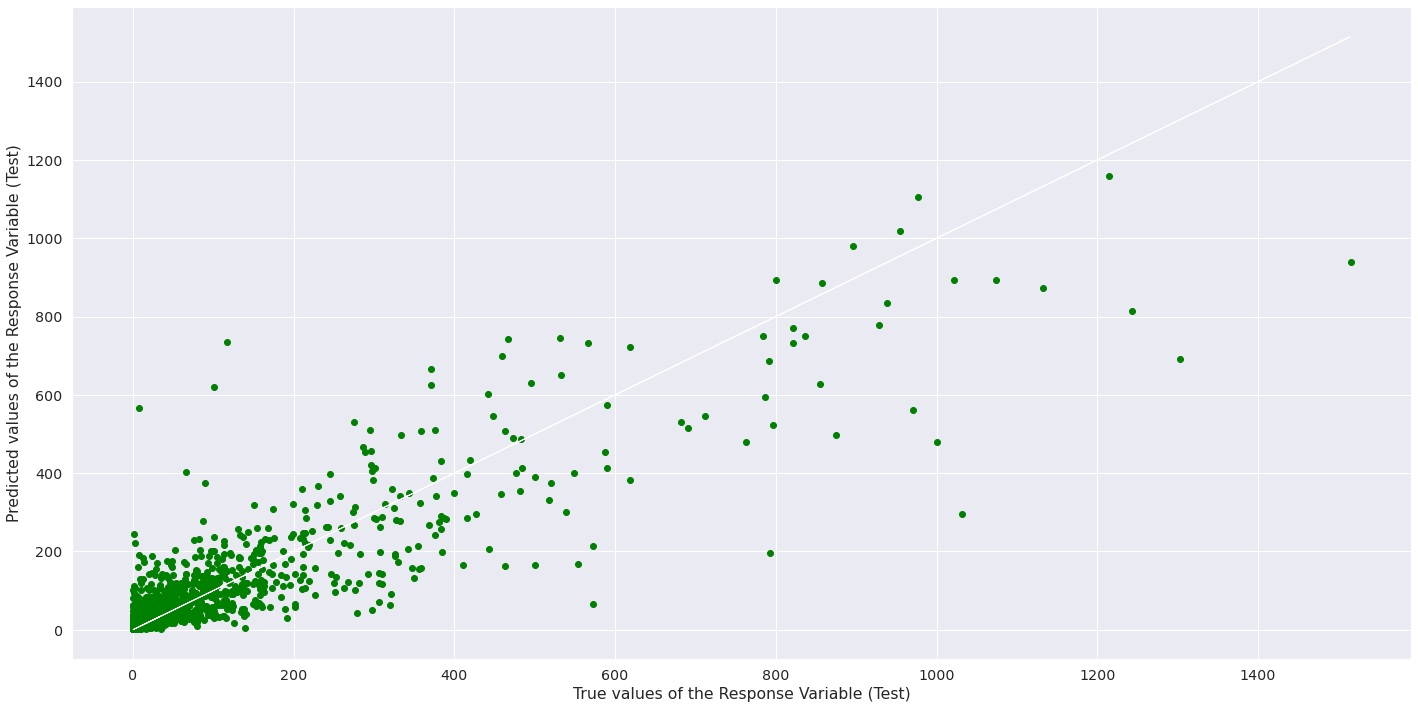

In [156]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, final_test_RandomForest_pred, color = "green")
axes.plot(y_test, y_test, 'w-', linewidth = 1)
axes.set_xlabel("True values of the Response Variable (Test)")
axes.set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [157]:
# Feature importance
feature_importances = grid_search_RandomForest.best_estimator_.feature_importances_
feature_importances

array([0.15651155, 0.05750836, 0.34922127, 0.04071503, 0.31613602,
       0.0668876 , 0.00450466, 0.00205379, 0.00317753, 0.00202735,
       0.00125685])

In [158]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
4840,-0.175280,2.707253,-0.470021,0.724541,-0.547364,-0.897930,0.0,1.0,0.0,0.0,0.0
4215,-0.130440,-0.361862,-0.654663,1.264704,-0.352477,-0.584810,0.0,0.0,1.0,0.0,0.0
6552,-0.225813,-1.139947,-0.611062,-2.516440,-0.568571,-1.100948,1.0,0.0,0.0,0.0,0.0
2799,0.055900,-0.837358,-0.575801,0.400443,1.143361,0.974977,0.0,0.0,1.0,0.0,0.0
1345,-0.021370,-1.096720,1.680853,-0.031688,-0.397085,-0.039208,0.0,0.0,1.0,0.0,0.0


**Hence we can tell that the most important feature is Vote_Count, which also has the highest correlation with Revenue**

### Randomized search to improve best model

Does it faster than gridsearch for large dataset but not always better than gridsearch. Randomised

In [159]:
#Imports

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [160]:
%%time

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

CPU times: user 54.8 s, sys: 131 ms, total: 54.9 s
Wall time: 54.9 s


In [161]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

88.29086111719273 {'max_features': 7, 'n_estimators': 180}
91.35422718113549 {'max_features': 5, 'n_estimators': 15}
87.56912910223919 {'max_features': 3, 'n_estimators': 72}
89.67632871051794 {'max_features': 5, 'n_estimators': 21}
88.28871704218776 {'max_features': 7, 'n_estimators': 122}
87.4970261312943 {'max_features': 3, 'n_estimators': 75}
87.75051759070314 {'max_features': 3, 'n_estimators': 88}
88.20909096909804 {'max_features': 5, 'n_estimators': 100}
87.98689918468692 {'max_features': 3, 'n_estimators': 150}
108.54247953983386 {'max_features': 5, 'n_estimators': 2}


In [162]:
rnd_search.best_params_

{'max_features': 3, 'n_estimators': 75}

In [163]:
# Feature importance
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.16010081, 0.06716639, 0.29462715, 0.05165177, 0.33132105,
       0.07739925, 0.00679284, 0.00345609, 0.00408769, 0.0020418 ,
       0.00135515])

In [164]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
4840,-0.175280,2.707253,-0.470021,0.724541,-0.547364,-0.897930,0.0,1.0,0.0,0.0,0.0
4215,-0.130440,-0.361862,-0.654663,1.264704,-0.352477,-0.584810,0.0,0.0,1.0,0.0,0.0
6552,-0.225813,-1.139947,-0.611062,-2.516440,-0.568571,-1.100948,1.0,0.0,0.0,0.0,0.0
2799,0.055900,-0.837358,-0.575801,0.400443,1.143361,0.974977,0.0,0.0,1.0,0.0,0.0
1345,-0.021370,-1.096720,1.680853,-0.031688,-0.397085,-0.039208,0.0,0.0,1.0,0.0,0.0


### Final Testing using best model after random search


In [165]:
# Using best model for predictions for new data
final_model = rnd_search.best_estimator_


final_test_pred = final_model.predict(X_test) #(test set)

final_mse = mean_squared_error(y_test, final_test_pred) # y_test
final_rmse = np.sqrt(final_mse)

print("root mean squared error is: ", final_rmse)

root mean squared error is:  81.0959654014733


### Thoughts about areas of improvement

1. One of the limits would be data collection. A good dataset would be about 100,000 data. Due to the lack of data from the website and ability to extract huge amounts of data, the train sets are often very overfitted. With better amount of data, the mean squared error will be further reduced
2. Since there are many outliers in the data, it could be further improved with better techniques that could remove outliers to median or average for better estimates.

In [166]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Predictions :\n", final_model_RandomForest.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Predictions :
 [ 23.71332457   7.92551477  43.19298787 252.0198224  192.6143754
  92.4284554   13.38706667 127.7839775  237.698081    77.1155379 ]

Labels :
 [34.57378, 6.045657, 3.445, 222.8096, 113.280098, 124.827316, 34.251525, 207.515725, 100.546153, 116.476887]


## Section 6: Data insights on Revenue
**Based on model**
1. Most important feature based on both searches is **Vote_Count**
2. Random Forest Regressor is the best model out of the 4 to predict Revenue
3. Features with low correlation are still useful in prediction when using **Random Forest Regressor** model. (As shown in the increase in RMSE when removing low correlation features)

**Limitation**
1. Revenue is left skewed hence raises RMSE due to lack of data in areas of high revenue (Hence can either log or maybe treat as a classification problem)
2. Lack of Data collected. A good size is 100,000. Leads to very overfitted training dataset which leads to bad predictions on test set.
3. Presense of many outliers which will affect RMSE.


### Revenue as a classification problem

Possible to use it as a classification problem instead of a Regression, might have better accuracy

Use of **Stratified Sampling**

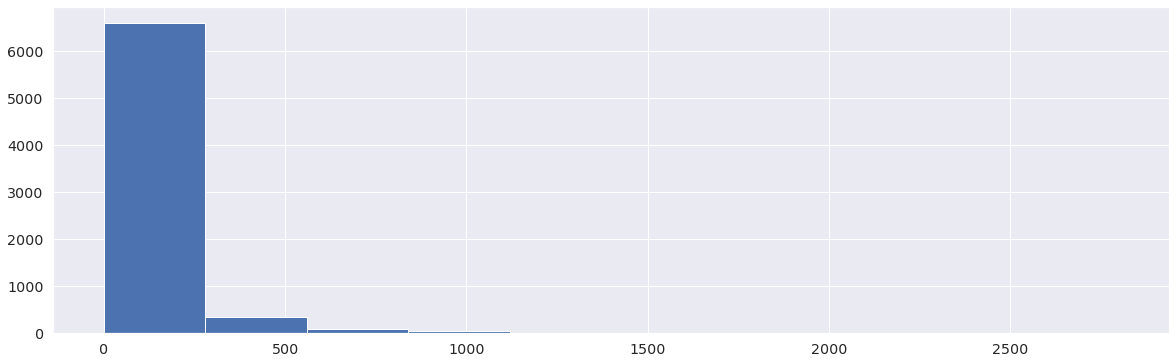

In [167]:
partial_dataset['Revenue'].hist(figsize=(20,6))

In [168]:
partial_dataset["Revenue"].describe()

count    7139.000000
mean       84.199345
std       170.523646
min         0.350000
25%         5.591677
50%        23.355100
75%        85.290125
max      2797.800564
Name: Revenue, dtype: float64

In [169]:
partial_dataset["Revenue_Category"] = pd.cut(partial_dataset["Revenue"],
                                           bins=[0, 6, 23, 85, 300, np.inf],
                                           labels=[1, 2, 3, 4, 5])

print(partial_dataset["Revenue_Category"].value_counts())

1    1863
3    1800
2    1686
4    1295
5     495
Name: Revenue_Category, dtype: int64


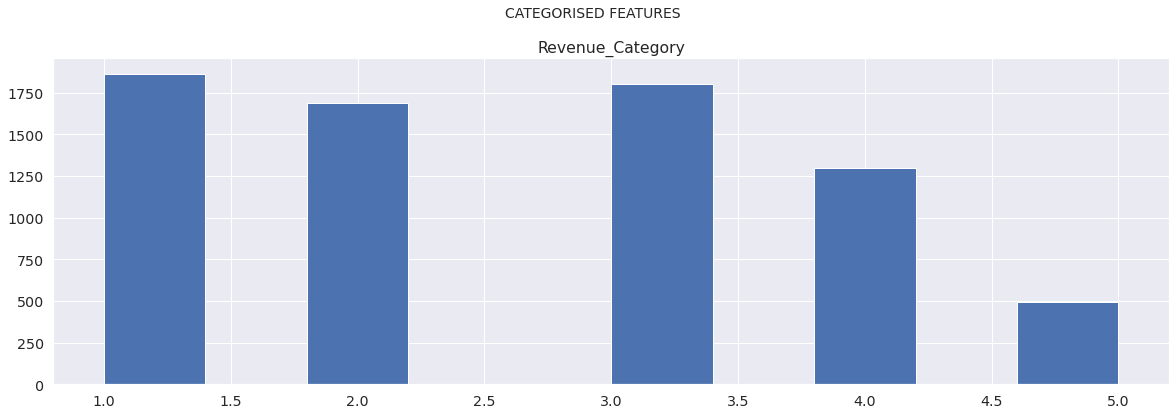

Counts for each categories of the respective features :
-------------------------------------------------------
1    1863
3    1800
2    1686
4    1295
5     495
Name: Revenue_Category, dtype: int64


In [170]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
fig.suptitle('Categorised Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes.set_title('Revenue_Category')
partial_dataset['Revenue_Category'].hist(ax=axes)

plt.show()

print("Counts for each categories of the respective features :")
print("-------------------------------------------------------")
print(partial_dataset["Revenue_Category"].value_counts())

In [171]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split based on the y-label, 'Duration_Category'
for train_index, test_index in split.split(partial_dataset, partial_dataset["Revenue_Category"]):
    strat_train_set = partial_dataset.loc[train_index]
    strat_test_set = partial_dataset.loc[test_index]

# The test set generated using stratified sampling has duration category proportions almost identical to those in the full dataset
# This is to prevent skewed test set that is generated via purely random sampling
print("Stratified Shuffle Split test set :\n", strat_test_set["Revenue_Category"].value_counts() / len(strat_test_set))
print()
print("Original distribution for data set (with respect to selected target) :\n",
      partial_dataset["Revenue_Category"].value_counts() / len(complete_data))

Stratified Shuffle Split test set :
 1    0.261204
3    0.252101
2    0.235994
4    0.181373
5    0.069328
Name: Revenue_Category, dtype: float64

Original distribution for data set (with respect to selected target) :
 1    0.260961
3    0.252136
2    0.236168
4    0.181398
5    0.069337
Name: Revenue_Category, dtype: float64


The returned stratified randomized folds from "StratifiedShuffleSplit" are made by preserving the percentage of samples for each class.

Split stratification is done based on the target, y labels (eg. 'Revenue')

Shows that Stratified sampling is better used to prevent skewed test set that is generated via purely random sampling

### Testing effect on accuracy if removing low correlation features/predictors
**Remove 'Duration', 'Vote_Average', 'Movie_Popularity'**

In [172]:
#Correlation of all variables with Revenue alone

corr_matrix = complete_data.corr()
corr_matrix["Revenue"].sort_values(ascending=False)

Revenue             1.000000
Vote_Count          0.748301
Budget              0.686622
Actor_Popularity    0.325173
Vote_Average        0.164675
Movie_Popularity    0.151456
Duration            0.123479
Actor_Index         0.093147
Year                0.022873
ID                  0.010265
Name: Revenue, dtype: float64

In [173]:
X_train

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
4840,-0.175280,2.707253,-0.470021,0.724541,-0.547364,-0.897930,0.0,1.0,0.0,0.0,0.0
4215,-0.130440,-0.361862,-0.654663,1.264704,-0.352477,-0.584810,0.0,0.0,1.0,0.0,0.0
6552,-0.225813,-1.139947,-0.611062,-2.516440,-0.568571,-1.100948,1.0,0.0,0.0,0.0,0.0
2799,0.055900,-0.837358,-0.575801,0.400443,1.143361,0.974977,0.0,0.0,1.0,0.0,0.0
1345,-0.021370,-1.096720,1.680853,-0.031688,-0.397085,-0.039208,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.094127,0.156862,-0.199692,0.184377,-0.312622,0.130986,1.0,0.0,0.0,0.0,0.0
5191,-0.120459,0.027181,-0.246706,-0.247753,-0.032907,0.449276,0.0,0.0,0.0,0.0,1.0
5226,-0.217881,1.021401,-0.587555,-1.112015,-0.564549,-1.032198,0.0,1.0,0.0,0.0,0.0
5390,-0.044630,2.361437,-0.552295,2.020933,0.519212,-0.545783,0.0,0.0,1.0,0.0,0.0


In [174]:
X_train_new = X_train.drop(columns = ['Movie_Popularity', 'Vote_Average', 'Duration'])
X_train_new

,Budget,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
4840,-0.470021,-0.547364,-0.897930,0.0,1.0,0.0,0.0,0.0
4215,-0.654663,-0.352477,-0.584810,0.0,0.0,1.0,0.0,0.0
6552,-0.611062,-0.568571,-1.100948,1.0,0.0,0.0,0.0,0.0
2799,-0.575801,1.143361,0.974977,0.0,0.0,1.0,0.0,0.0
1345,1.680853,-0.397085,-0.039208,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3772,-0.199692,-0.312622,0.130986,1.0,0.0,0.0,0.0,0.0
5191,-0.246706,-0.032907,0.449276,0.0,0.0,0.0,0.0,1.0
5226,-0.587555,-0.564549,-1.032198,0.0,1.0,0.0,0.0,0.0
5390,-0.552295,0.519212,-0.545783,0.0,0.0,1.0,0.0,0.0


In [175]:
X_test

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
3027,-0.130809,0.372997,-0.458267,0.292410,-0.537857,-0.476258,1.0,0.0,0.0,0.0,0.0
5272,-0.165990,-0.145727,-0.458267,-0.247753,-0.554677,1.169724,1.0,0.0,0.0,0.0,0.0
5790,-0.079895,-0.750904,0.123439,0.832574,-0.378803,-1.128603,0.0,0.0,1.0,0.0,0.0
696,0.004569,-0.232181,0.505512,0.400443,0.955056,2.063209,0.0,0.0,1.0,0.0,0.0
1423,-0.084111,0.718812,0.975648,0.184377,0.217558,1.151503,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
59,0.860331,1.151082,2.856193,1.372737,4.829757,0.348478,0.0,0.0,1.0,0.0,0.0
7132,-0.200505,-0.750904,-0.668183,-1.544146,-0.566377,-1.004673,0.0,0.0,1.0,0.0,0.0
787,-0.145434,-0.016046,-0.317226,-0.355786,0.063257,1.583255,1.0,0.0,0.0,0.0,0.0
2534,-0.084218,-0.664450,-0.293720,-0.031688,-0.254485,2.063209,1.0,0.0,0.0,0.0,0.0


In [176]:
X_test_new = X_test.drop(columns = ['Movie_Popularity', 'Vote_Average', 'Duration'])
X_test_new

,Budget,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
3027,-0.458267,-0.537857,-0.476258,1.0,0.0,0.0,0.0,0.0
5272,-0.458267,-0.554677,1.169724,1.0,0.0,0.0,0.0,0.0
5790,0.123439,-0.378803,-1.128603,0.0,0.0,1.0,0.0,0.0
696,0.505512,0.955056,2.063209,0.0,0.0,1.0,0.0,0.0
1423,0.975648,0.217558,1.151503,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
59,2.856193,4.829757,0.348478,0.0,0.0,1.0,0.0,0.0
7132,-0.668183,-0.566377,-1.004673,0.0,0.0,1.0,0.0,0.0
787,-0.317226,0.063257,1.583255,1.0,0.0,0.0,0.0,0.0
2534,-0.293720,-0.254485,2.063209,1.0,0.0,0.0,0.0,0.0


**Tuned Linear Regression Scores**

**Actually worst after removal of low correlation features/predictors**

In [177]:
grid_search_LinearReg.fit(X_train_new, y_train)

# Using tuned linear reg for predictions for new data
final_model_LinearReg = grid_search_LinearReg.best_estimator_


final_test_LinearReg_pred = final_model_LinearReg.predict(X_test_new) #(test set)

final_mse_LinearReg = mean_squared_error(y_test, final_test_LinearReg_pred) # y_test
final_rmse_LinearReg = np.sqrt(final_mse_LinearReg)

print("Linear Regression:\n")
print("root mean squared error of test is: ", final_rmse_LinearReg)

Linear Regression:

root mean squared error of test is:  95.93265707002286


**Tuned Decision Tree Scores**

**Worst after removal of low correlation features/predictors**

In [178]:
param_grid = [
              { 'criterion': ['mse', 'friedman_mse', 'mae'],
                'splitter': ['best','random'],
                'max_depth': [2,4,6,8,10,12],
                'max_features': [2, 4, 6, 8]
              }
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_DecisionTree = GridSearchCV(tree_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_DecisionTree.fit(X_train_new, y_train)

# Using tuned Decision Tree for predictions for new data
final_model_DecisionTree = grid_search_DecisionTree.best_estimator_


final_test_DecisionTree_pred = final_model_DecisionTree.predict(X_test_new) #(test set)

final_mse_DecisionTree = mean_squared_error(y_test, final_test_DecisionTree_pred) # y_test
final_rmse_DecisionTree = np.sqrt(final_mse_DecisionTree)


In [179]:
print("Decision Tree: \n")
print("root mean squared error of test is: ", final_rmse_DecisionTree)

Decision Tree: 

root mean squared error of test is:  97.56863230343608


**Tuned Random Forest Regressor Scores**

**Performs worst after removal as Random Forest does splits based on independent variables hence the more independent the variables the better the accuracy**

In [180]:
param_grid = [
    # combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8], 
     'bootstrap': [True,False]
     }, 
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_RandomForest = GridSearchCV(forest_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_RandomForest.fit(X_train_new, y_train)

# Using tuned Random Forest model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_


final_test_RandomForest_pred = final_model_RandomForest.predict(X_test_new) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)


In [181]:
print("Random Forest: \n")
print("root mean squared error is: ", final_rmse_RandomForest)

Random Forest: 

root mean squared error is:  90.12306044862082
